In [20]:
# Cell 1: Imports and constants
import numpy as np
from functools import lru_cache
import matplotlib.pyplot as plt

X, O, E = 1, -1, 0  # players and empty
BOARD_SHAPE = (3, 3)

def flat(board: np.ndarray) -> tuple:
    return tuple(board.astype(int).ravel().tolist())


In [21]:
# Cell 2: Win/draw detector
WIN_LINES = [
    [(0,0),(0,1),(0,2)], [(1,0),(1,1),(1,2)], [(2,0),(2,1),(2,2)],  # rows
    [(0,0),(1,0),(2,0)], [(0,1),(1,1),(2,1)], [(0,2),(1,2),(2,2)],  # cols
    [(0,0),(1,1),(2,2)], [(0,2),(1,1),(2,0)]                        # diags
]

def check_winner(board: np.ndarray):
    for line in WIN_LINES:
        s = sum(board[r, c] for r, c in line)
        if s == 3:   return X
        if s == -3:  return O
    if not (board == E).any():  # full board
        return 0  # draw
    return None  # non-terminal


In [22]:
# Cell 3: Exact enumeration with memoization
@lru_cache(maxsize=None)
def solve_counts(board_key: tuple, player: int):
    board = np.array(board_key, dtype=int).reshape(BOARD_SHAPE)
    term = check_winner(board)
    if term is not None:
        if term == X: return (1, 0, 0, 1)
        if term == O: return (0, 1, 0, 1)
        return (0, 0, 1, 1)  # draw

    xw = ow = dr = tt = 0
    for r in range(3):
        for c in range(3):
            if board[r, c] == E:
                board[r, c] = player
                sub = solve_counts(flat(board), -player)
                board[r, c] = E
                xw += sub[0]; ow += sub[1]; dr += sub[2]; tt += sub[3]
    return (xw, ow, dr, tt)

# Quick sanity at root
root = np.zeros(BOARD_SHAPE, dtype=int)
print("Root counts (xw, ow, dr, tt):", solve_counts(flat(root), X))


Root counts (xw, ow, dr, tt): (131184, 77904, 46080, 255168)


In [23]:
# Cell 4: Random-play win-rate map
def random_play_map(board: np.ndarray, player: int) -> np.ndarray:
    M = np.full_like(board, np.nan, dtype=float)
    for r in range(3):
        for c in range(3):
            if board[r, c] == E:
                board[r, c] = player
                xw, ow, dr, tt = solve_counts(flat(board), -player)
                board[r, c] = E
                M[r, c] = xw / tt  # always X's win rate
    return M

# Root map for X
M_root_X = random_play_map(root.copy(), X)
print(M_root_X.round(4))


[[0.5283 0.4809 0.5283]
 [0.4809 0.6048 0.4809]
 [0.5283 0.4809 0.5283]]


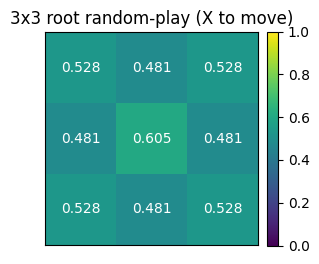

In [24]:
# Cell 5: Heatmap plotting
def plot_map(M: np.ndarray, title: str = "", cmap="viridis", vmin=0.0, vmax=1.0):
    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(np.nan_to_num(M, nan=np.nanmin(M)), cmap=cmap, vmin=vmin, vmax=vmax)
    for r in range(3):
        for c in range(3):
            if not np.isnan(M[r, c]):
                ax.text(c, r, f"{M[r,c]:.3f}", ha="center", va="center", color="white")
            else:
                ax.text(c, r, "·", ha="center", va="center", color="grey")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()

plot_map(M_root_X, "3x3 root random-play (X to move)")


Role reconstruction MSE=0.000000, argmax_match=1


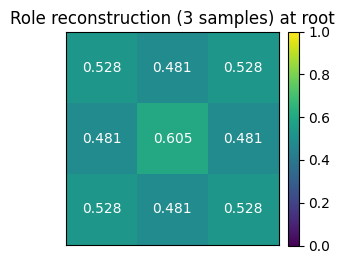

In [25]:
# Cell 6: Role masks
CENTER_MASK = np.zeros((3,3), dtype=bool); CENTER_MASK[1,1] = True
CORNER_MASK = np.zeros((3,3), dtype=bool); CORNER_MASK[0,0]=CORNER_MASK[0,2]=CORNER_MASK[2,0]=CORNER_MASK[2,2]=True
SIDE_MASK   = ~(CENTER_MASK | CORNER_MASK)

def sample_three_roles(M: np.ndarray):
    theta_center = float(M[CENTER_MASK][0])
    theta_corner = float(M[CORNER_MASK][0])
    theta_side   = float(M[SIDE_MASK][0])
    return theta_center, theta_corner, theta_side

def reconstruct_role_surface(theta_center, theta_corner, theta_side):
    return (theta_center*CENTER_MASK.astype(float) +
            theta_corner*CORNER_MASK.astype(float) +
            theta_side  *SIDE_MASK.astype(float))

# Fit from the exact root map
tc, tco, ts = sample_three_roles(M_root_X)
M_role = reconstruct_role_surface(tc, tco, ts)

# Metrics versus exact
mse = np.nanmean((M_role - M_root_X)**2)
argmax_match = np.nanargmax(M_role) == np.nanargmax(M_root_X)
print(f"Role reconstruction MSE={mse:.6f}, argmax_match={int(argmax_match)}")
plot_map(M_role, "Role reconstruction (3 samples) at root")


In [26]:
# Cell 7 (optional): Perfect-play evaluator for 3x3
@lru_cache(maxsize=None)
def solve_value(board_key: tuple, player: int):
    board = np.array(board_key, dtype=int).reshape(3,3)
    term = check_winner(board)
    if term is not None:
        return (1 if term==X else -1 if term==O else 0), None
    best_val = -2  # worse than loss
    best_move = None
    for r in range(3):
        for c in range(3):
            if board[r, c] == E:
                board[r, c] = player
                v, _ = solve_value(flat(board), -player)
                board[r, c] = E
                v = -v  # from current player's perspective
                if v > best_val:
                    best_val, best_move = v, (r, c)
                    if best_val == 1:
                        return 1, best_move
    return best_val, best_move

val, mv = solve_value(flat(root), X)
print("Perfect-play root value:", val, "example optimal move:", mv)


Perfect-play root value: -1 example optimal move: (0, 0)


In [27]:
# Cell 8: BFS layers from root (3x3)
from collections import deque, defaultdict

def bfs_layers_3x3():
    start = (flat(np.zeros((3,3), dtype=int)), X)
    layers = defaultdict(list)  # depth -> list of (board_key, player)
    q = deque([(start, 0)])
    seen = set([start])
    while q:
        (bkey, p), d = q.popleft()
        board = np.array(bkey, dtype=int).reshape(3,3)
        if check_winner(board) is not None:
            continue  # terminal, do not expand
        layers[d].append((bkey, p))
        for r in range(3):
            for c in range(3):
                if board[r,c] == E:
                    board[r,c] = p
                    nbkey = flat(board)
                    board[r,c] = E
                    nxt = (nbkey, -p)
                    if nxt not in seen:
                        seen.add(nxt)
                        q.append((nxt, d+1))
    return dict(sorted(layers.items()))

LAYERS = bfs_layers_3x3()
print({d: len(v) for d, v in LAYERS.items()})


{0: 1, 1: 9, 2: 72, 3: 252, 4: 756, 5: 1140, 6: 1372, 7: 696, 8: 222}


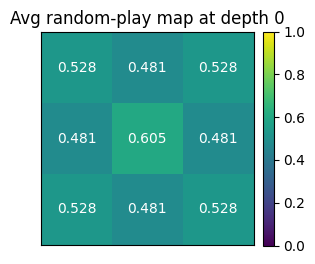

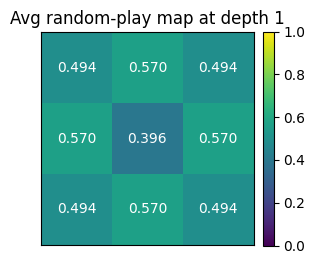

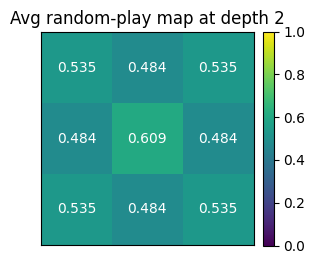

In [28]:
# Cell 9: Average maps per depth (X-win prob under random play)
def depth_avg_maps(layers):
    A = {}  # depth -> average map (3x3)
    C = {}  # depth -> count of contributions per cell (3x3)
    for d, states in layers.items():
        acc = np.zeros((3,3), dtype=float)
        cnt = np.zeros((3,3), dtype=int)
        for bkey, p in states:
            board = np.array(bkey, dtype=int).reshape(3,3)
            M = random_play_map(board, p)  # P(X wins) if p==X else P(O wins) but we keep "as computed"
            for r in range(3):
                for c in range(3):
                    if not np.isnan(M[r,c]):
                        acc[r,c] += M[r,c]
                        cnt[r,c] += 1
        with np.errstate(invalid="ignore"):
            A[d] = np.divide(acc, cnt, where=cnt>0)
        C[d] = cnt
    return A, C

A_depth, C_depth = depth_avg_maps(LAYERS)
# Quick visual check for a few plies
for d in sorted(A_depth.keys())[:3]:
    plot_map(A_depth[d], f"Avg random-play map at depth {d}")


center [0.6048, 0.3957, 0.6092, 0.3996, 0.664, 0.3631, 0.719, 0.2766, 0.7895]
corner [0.5283, 0.4941, 0.5349, 0.5007, 0.5828, 0.4678, 0.625, 0.3804, 0.6786]
side [0.4809, 0.5701, 0.4842, 0.5801, 0.5191, 0.558, 0.5405, 0.4855, 0.5]


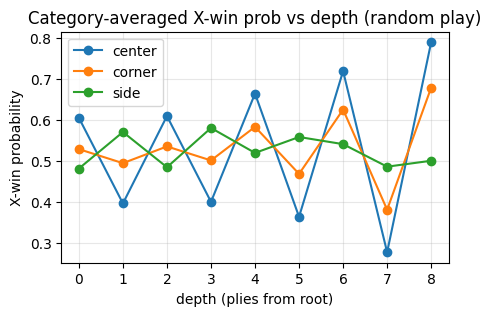


Plotting individual position values per depth...


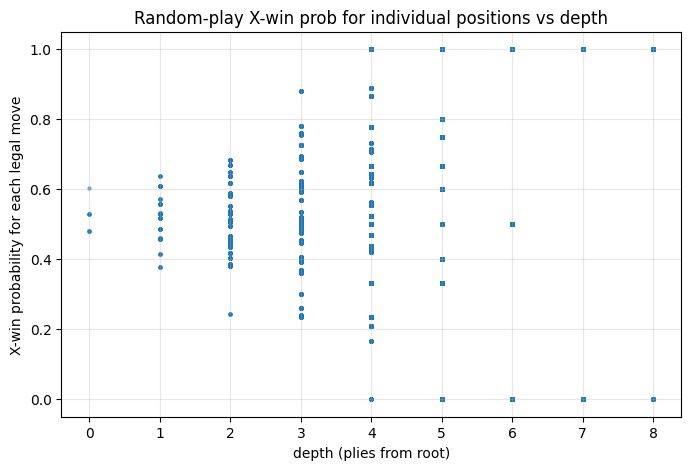


Plotting average X-win probability for each position across depths...


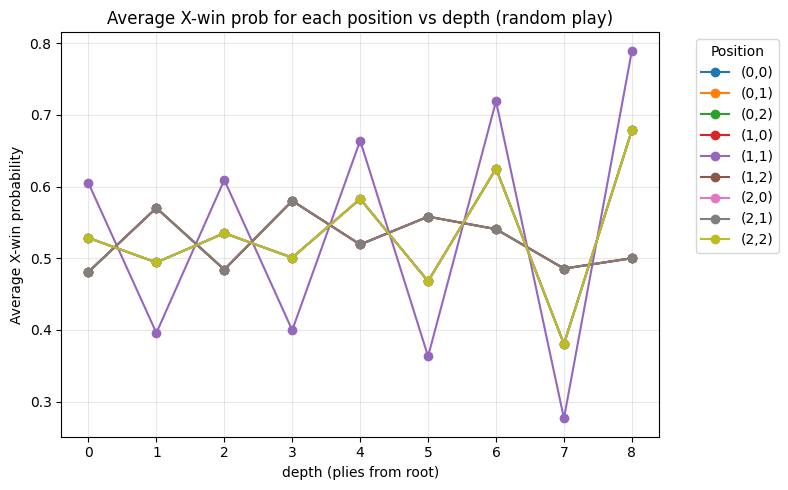

In [36]:
# Cell 10: Extract role curves vs depth
ROLES = {
    "center": CENTER_MASK,
    "corner": CORNER_MASK,
    "side":   SIDE_MASK
}

def role_curves(A_depth):
    depths = sorted(A_depth.keys())
    curves = {name: [] for name in ROLES.keys()}
    for d in depths:
        M = A_depth[d]
        for name, mask in ROLES.items():
            vals = M[mask]
            vals = vals[~np.isnan(vals)]
            curves[name].append(float(np.mean(vals)) if vals.size else np.nan)
    return depths, curves

depths, curves = role_curves(A_depth)
for name in ROLES.keys():
    print(name, [round(v,4) for v in curves[name]])
# Plot
plt.figure(figsize=(5,3))
for name in ROLES.keys():
    plt.plot(depths, curves[name], marker="o", label=name)
plt.xlabel("depth (plies from root)"); plt.ylabel("X-win probability")
plt.title("Category-averaged X-win prob vs depth (random play)")
plt.legend(); plt.grid(alpha=0.3); plt.show()

# --- Additional plot requested by user ---
print("\nPlotting individual position values per depth...")
plt.figure(figsize=(8, 5))
all_depths = sorted(LAYERS.keys())
values = [] # Initialize values list outside the loop
for d in all_depths:
    for bkey, p in LAYERS[d]:
        board = np.array(bkey, dtype=int).reshape(BOARD_SHAPE)
        M = random_play_map(board, p) # always X-win perspective from child
        vals = M[~np.isnan(M)]
        # Only plot values for legal moves
        for val in vals:
            values.append((d, val))

if values:
    depths_plot, values_plot = zip(*values)
    plt.scatter(depths_plot, values_plot, alpha=0.5, s=5)
    plt.xlabel("depth (plies from root)")
    plt.ylabel("X-win probability for each legal move")
    plt.title("Random-play X-win prob for individual positions vs depth")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No data to plot for individual positions.")


# --- New plot: Average map values for each of the 9 positions across depths ---
print("\nPlotting average X-win probability for each position across depths...")
plt.figure(figsize=(8, 5))

# Collect average values for each position at each depth
position_values = { (r, c): [] for r in range(3) for c in range(3) }
available_depths = sorted(A_depth.keys())

for d in available_depths:
    avg_map = A_depth[d]
    for r in range(3):
        for c in range(3):
            position_values[(r, c)].append(float(avg_map[r, c]) if not np.isnan(avg_map[r, c]) else np.nan)

# Plot each position's curve
for (r, c), values in position_values.items():
    plt.plot(available_depths, values, marker="o", linestyle='-', label=f'({r},{c})')

plt.xlabel("depth (plies from root)")
plt.ylabel("Average X-win probability")
plt.title("Average X-win prob for each position vs depth (random play)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

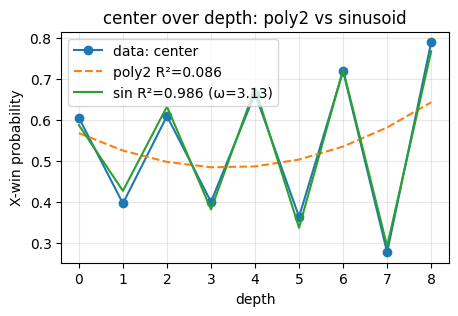

center: Poly2 R²=0.086 | Sin R²=0.986 (omega=3.13)


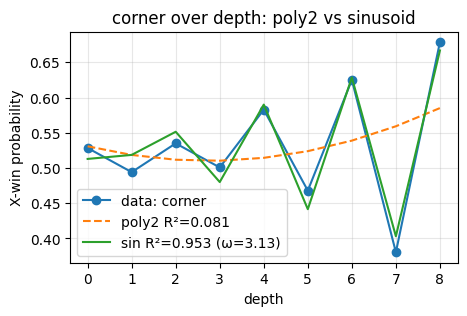

corner: Poly2 R²=0.081 | Sin R²=0.953 (omega=3.13)


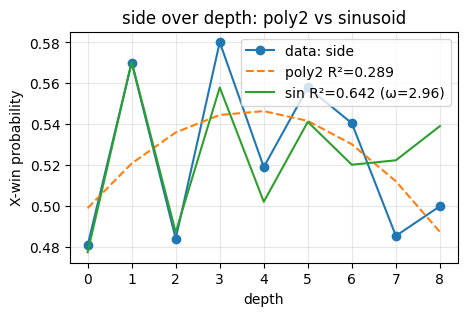

side: Poly2 R²=0.289 | Sin R²=0.642 (omega=2.96)


In [11]:
# Cell 11: robust sine and poly fits (drop-in replacement)

from numpy.linalg import lstsq

def compute_r2(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    if ss_tot <= 0:
        # constant series: perfect fit if yhat==y, else undefined -> return 0.0
        return 1.0 if np.allclose(y, yhat) else 0.0
    return 1.0 - ss_res/ss_tot

def fit_poly2(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    Xv = np.vstack([np.ones_like(x), x, x**2]).T
    coef, _, _, _ = lstsq(Xv, y, rcond=None)
    yhat = Xv @ coef
    return coef, yhat, compute_r2(y, yhat)

def fit_sine(x, y, omegas=np.linspace(0.1, np.pi, 200)):
    x = np.asarray(x, float); y = np.asarray(y, float)
    # guard NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]; y = y[mask]
    best = (None, None, None, -np.inf)  # (w, coef, yhat, r2)
    for w in omegas:
        Xs = np.vstack([np.ones_like(x), np.cos(w*x), np.sin(w*x)]).T
        coef, _, _, _ = lstsq(Xs, y, rcond=None)
        yhat = Xs @ coef
        r2 = compute_r2(y, yhat)
        if r2 > best[3]:
            best = (w, coef, yhat, r2)
    return best  # (omega, coef, yhat, r2)

def plot_role_fits(depths, curves):
    x_all = np.array(depths, dtype=float)
    for name, series in curves.items():
        y_all = np.array(series, dtype=float)
        mask = np.isfinite(y_all)
        x, y = x_all[mask], y_all[mask]
        pcoef, pyhat, pr2 = fit_poly2(x, y)
        w, scoef, syhat, sr2 = fit_sine(x, y)
        plt.figure(figsize=(5,3))
        plt.plot(x, y, 'o-', label=f"data: {name}")
        plt.plot(x, pyhat, '--', label=f"poly2 R²={pr2:.3f}")
        if w is not None:
            plt.plot(x, syhat, '-', label=f"sin R²={sr2:.3f} (ω={w:.2f})")
        plt.xlabel("depth"); plt.ylabel("X-win probability")
        plt.title(f"{name} over depth: poly2 vs sinusoid")
        plt.legend(); plt.grid(alpha=0.3); plt.show()
        print(f"{name}: Poly2 R²={pr2:.3f} | Sin R²={sr2:.3f} (omega={w if w is not None else float('nan'):.2f})")

# Re-run
plot_role_fits(depths, curves)


In [38]:
# Cell 12: Collect coefficients for reuse
import pandas as pd

def gather_fit_table(depths, curves):
    x = np.array(depths, dtype=float)
    rows = []
    for name, series in curves.items():
        y = np.array(series, dtype=float)
        mask = np.isfinite(y)
        x_, y_ = x[mask], y[mask]
        # poly
        pcoef, pyhat, pr2 = fit_poly2(x_, y_)
        # sine
        w, scoef, syhat, sr2 = fit_sine(x_, y_)
        rows.append({
            "role": name,
            "poly_bias": pcoef[0], "poly_lin": pcoef[1], "poly_quad": pcoef[2], "poly_R2": pr2,
            "sin_w": w, "sin_a": scoef[0], "sin_b": scoef[1], "sin_c": scoef[2], "sin_R2": sr2
        })
    return pd.DataFrame(rows)

fit_table = gather_fit_table(depths, curves)
fit_table


,role,poly_bias,poly_lin,poly_quad,poly_R2,sin_w,sin_a,sin_b,sin_c,sin_R2
0,center,0.567554,-0.050129,0.007442,0.086124,3.126308,0.518051,0.068943,-1.482229,0.985534
1,corner,0.530779,-0.014982,0.002721,0.080966,3.126308,0.525355,-0.012496,-1.261765,0.952591
2,side,0.499051,0.025143,-0.003324,0.288657,2.958180,0.526087,-0.048552,-0.018143,0.641506


In [13]:
# Cell X: 3x3 next-move API with tactics gating + blended predictor

# Dependencies expected from earlier cells:
# - WIN_LINES, check_winner(board), X=1, O=-1, E=0
# - Optional: fit_table (3x3 role-depth fits); else we fall back to exact arrays

import numpy as np

# 1) Tactics: immediate win / immediate block for 3x3 (K=3)
def has_immediate_win_3(board: np.ndarray, player: int):
    for (r,c) in [(r,c) for r in range(3) for c in range(3) if board[r,c]==E]:
        board[r,c] = player
        if check_winner(board) == player:
            board[r,c] = E
            return (r,c)
        board[r,c] = E
    return None

# 2) Role masks (center / corner / side)
CENTER_MASK = np.zeros((3,3), dtype=bool); CENTER_MASK[1,1] = True
CORNER_MASK = np.zeros((3,3), dtype=bool); CORNER_MASK[0,0]=CORNER_MASK[0,2]=CORNER_MASK[2,0]=CORNER_MASK[2,2]=True
SIDE_MASK   = ~(CENTER_MASK | CORNER_MASK)

# 3) Exact role-by-depth arrays (fallback if no fit_table is defined)
CENTER_SER = np.array([0.6048, 0.4060, 0.6092, 0.4120, 0.6640, 0.4723, 0.7190, 0.5106, 0.7895], dtype=float)
CORNER_SER = np.array([0.5283, 0.3316, 0.5349, 0.3386, 0.5828, 0.3843, 0.6250, 0.4049, 0.6786], dtype=float)
SIDE_SER   = np.array([0.4809, 0.2541, 0.4842, 0.2609, 0.5191, 0.2904, 0.5405, 0.2609, 0.5000], dtype=float)

def role_prior_from_depth_3x3(depth: int, fit_table=None):
    # Use fitted sinusoids if available; else fallback to exact arrays above
    d = int(np.clip(depth, 0, 8))
    if fit_table is None:
        return {
            "center": float(CENTER_SER[d]),
            "corner": float(CORNER_SER[d]),
            "side":   float(SIDE_SER[d]),
        }
    # Fit-table path (expects columns: role, sin_w, sin_a, sin_b, sin_c)
    vals = {}
    for role in ["center","corner","side"]:
        row = fit_table[fit_table["role"]==role]
        if row.empty:
            # fallback if a role row is missing
            vals[role] = float({"center":CENTER_SER,"corner":CORNER_SER,"side":SIDE_SER}[role][d])
        else:
            w = float(row["sin_w"].iloc[0]); a=float(row["sin_a"].iloc[0]); b=float(row["sin_b"].iloc[0]); c=float(row["sin_c"].iloc[0])
            vals[role] = float(a + b*np.cos(w*d) + c*np.sin(w*d))
    return vals

# 4) Light local feature for shaping (open-2 / open-1 on empty cells)
def local_threat_3x3(board: np.ndarray, player: int):
    # Score empties higher if they are on lines with no opponent marks and ≥1 of player's marks
    H = np.zeros((3,3), dtype=float)
    for line in WIN_LINES:
        xs = os = 0
        empties = []
        for r,c in line:
            v = board[r,c]
            if v == X: xs += 1
            elif v == O: os += 1
            else: empties.append((r,c))
        if os == 0 and xs > 0 and player == X:
            for (r,c) in empties: H[r,c] += xs  # reward X’s progress
        if xs == 0 and os > 0 and player == O:
            for (r,c) in empties: H[r,c] += os  # reward O’s progress
    return H

def normalize01(M):
    v = M[np.isfinite(M)]
    if v.size == 0 or np.allclose(v.min(), v.max()):
        return np.zeros_like(M, dtype=float)
    return (M - v.min()) / (v.max() - v.min())

# 5) Blended predictor (role prior + local feature)
def blended_map_3x3(board: np.ndarray, player: int, fit_table=None, beta_threat=0.15):
    d = int(np.count_nonzero(board != 0))  # ply depth
    prior = role_prior_from_depth_3x3(d, fit_table=fit_table)
    M = (prior["center"]*CENTER_MASK.astype(float) +
         prior["corner"]*CORNER_MASK.astype(float) +
         prior["side"]  *SIDE_MASK.astype(float))
    # mask illegal
    M = np.where(board==0, M, np.nan)
    # local shaping
    T = normalize01(local_threat_3x3(board, player))
    M_eff = np.where(np.isnan(M), np.nan, M + beta_threat*T)
    return M_eff

# 6) Unified API: next move for any 3x3 board
def next_move_any_3x3(board: np.ndarray, player: int, fit_table=None, beta_threat=0.15):
    # 1) immediate win
    mv = has_immediate_win_3(board, player)
    if mv is not None:
        return mv
    # 2) immediate block
    mv = has_immediate_win_3(board, -player)
    if mv is not None:
        return mv
    # 3) blended prior selection
    M_eff = blended_map_3x3(board, player, fit_table=fit_table, beta_threat=beta_threat)
    m = np.isfinite(M_eff)
    if not np.any(m):
        # fallback
        empties = [(r,c) for r in range(3) for c in range(3) if board[r,c]==0]
        return empties[0]
    idx = np.nanargmax(M_eff) if player==X else np.nanargmin(M_eff)
    r,c = np.unravel_index(idx, M_eff.shape)
    return (r,c)

# Demo:
b = np.zeros((3,3), dtype=int); b[1,1]=X; b[0,0]=O
print(next_move_any_3x3(b, X))


(np.int64(0), np.int64(2))


In [14]:
# Cell 13: Context starts and BFS layers (3x3)

# Reuse: check_winner, random_play_map (always X-win perspective), etc.

def start_X_center():
    b = np.zeros((3,3), dtype=np.int8)
    b[1,1] = X
    return b

def start_X_corner():
    b = np.zeros((3,3), dtype=np.int8)
    b[0,0] = X
    return b

def start_X_side():
    b = np.zeros((3,3), dtype=np.int8)
    b[0,1] = X
    return b

CTX_STARTS = {
    "X@center": start_X_center,
    "X@corner": start_X_corner,
    "X@side":   start_X_side,
}

from collections import deque, defaultdict

def bfs_layers_from(board0: np.ndarray, player0: int):
    start = (flat(board0), player0)
    seen = set([start])
    q = deque([(start, 0)])
    layers = defaultdict(list)
    while q:
        (bkey, p), d = q.popleft()
        b = np.array(bkey, dtype=int).reshape(3,3)
        if check_winner(b) is not None:
            continue
        layers[d].append((bkey, p))
        for r in range(3):
            for c in range(3):
                if b[r,c] == E:
                    b[r,c] = p
                    nk = (flat(b), -p)
                    b[r,c] = E
                    if nk not in seen:
                        seen.add(nk)
                        q.append((nk, d+1))
    return dict(sorted(layers.items()))

LAYERS_CTX = {}
for name, make in CTX_STARTS.items():
    b0 = make().copy()
    LAYERS_CTX[name] = bfs_layers_from(b0, O)  # O to move after X's opener
    print(name, {d: len(v) for d,v in LAYERS_CTX[name].items()})

X@center {0: 1, 1: 8, 2: 56, 3: 168, 4: 360, 5: 444, 6: 256, 7: 92}
X@corner {0: 1, 1: 8, 2: 56, 3: 168, 4: 375, 5: 454, 6: 296, 7: 97}
X@side {0: 1, 1: 8, 2: 56, 3: 168, 4: 390, 5: 464, 6: 336, 7: 102}


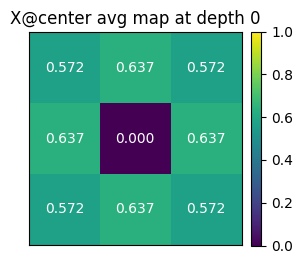

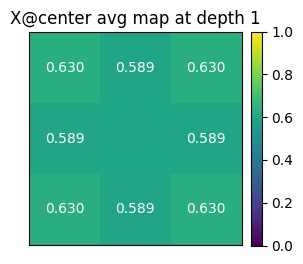

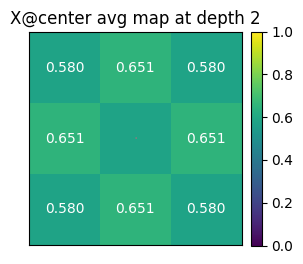

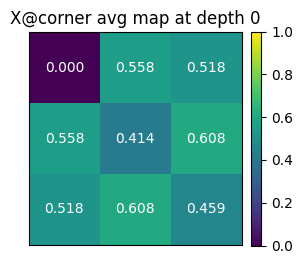

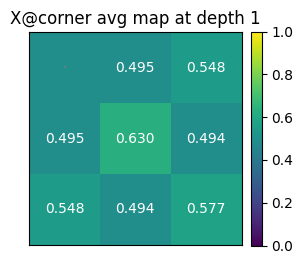

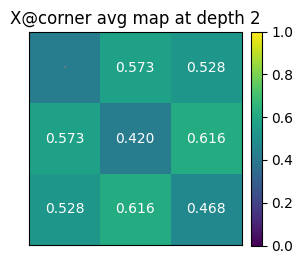

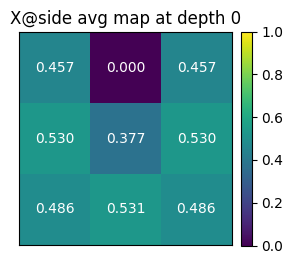

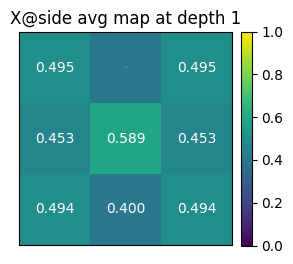

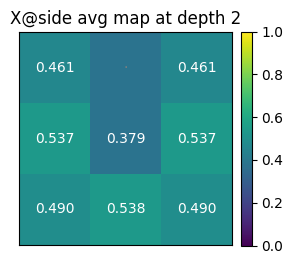

In [15]:
# Cell 14: Depth-averaged maps per context (X-win perspective)

def depth_avg_maps(layers):
    A = {}; C = {}
    for d, states in layers.items():
        acc = np.zeros((3,3), dtype=float)
        cnt = np.zeros((3,3), dtype=int)
        for bkey, p in states:
            b = np.array(bkey, dtype=int).reshape(3,3)
            M = random_play_map(b, p)  # always xw/tt from child state
            m = np.isfinite(M)
            acc[m] += M[m]; cnt[m] += 1
        with np.errstate(invalid="ignore"):
            A[d] = np.divide(acc, cnt, where=cnt>0)
        C[d] = cnt
    return A, C

A_ctx, C_ctx = {}, {}
for name in LAYERS_CTX:
    A_ctx[name], C_ctx[name] = depth_avg_maps(LAYERS_CTX[name])

# Quick visuals
for name in A_ctx:
    for d in sorted(A_ctx[name].keys())[:3]:
        plot_map(A_ctx[name][d], f"{name} avg map at depth {d}")


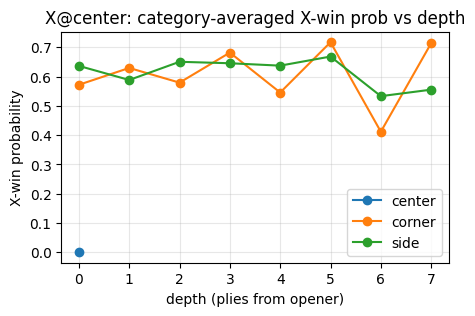

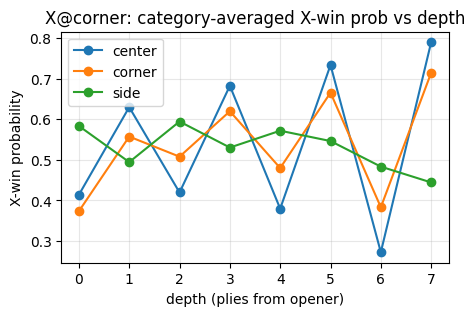

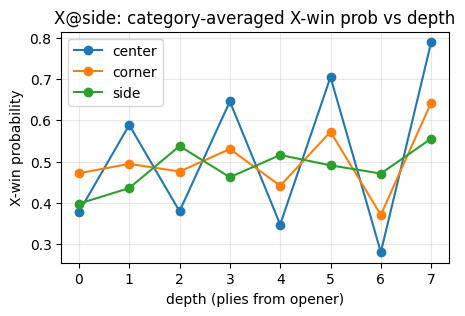


Plotting average X-win probability for each position across depths per context...


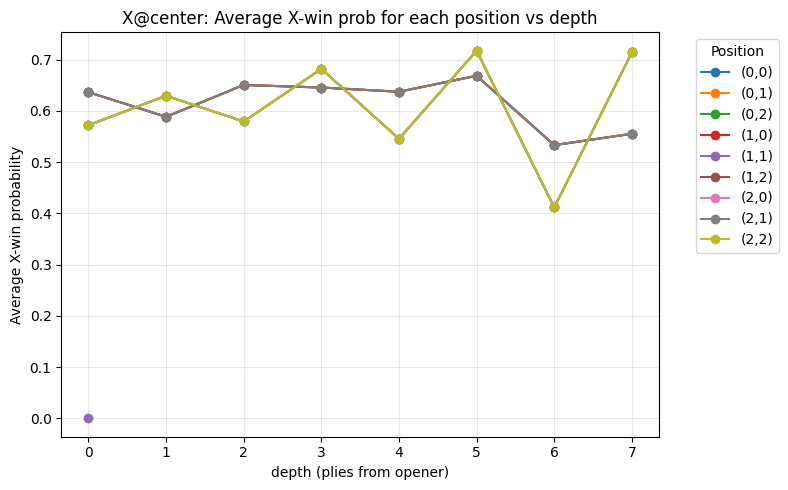

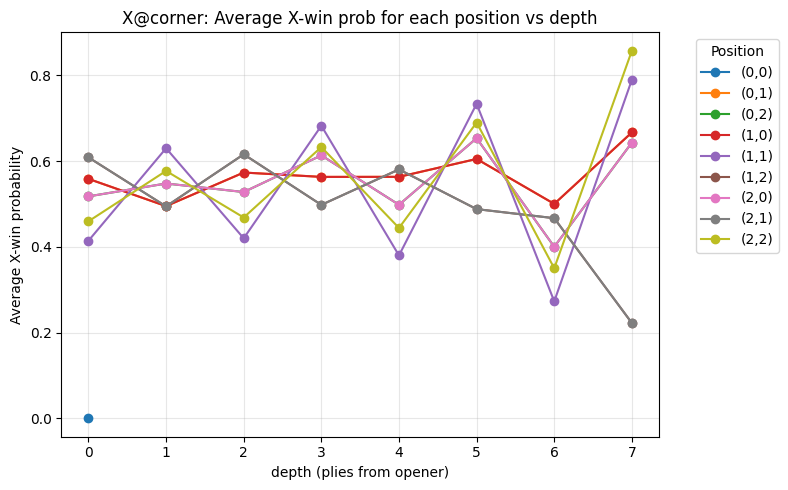

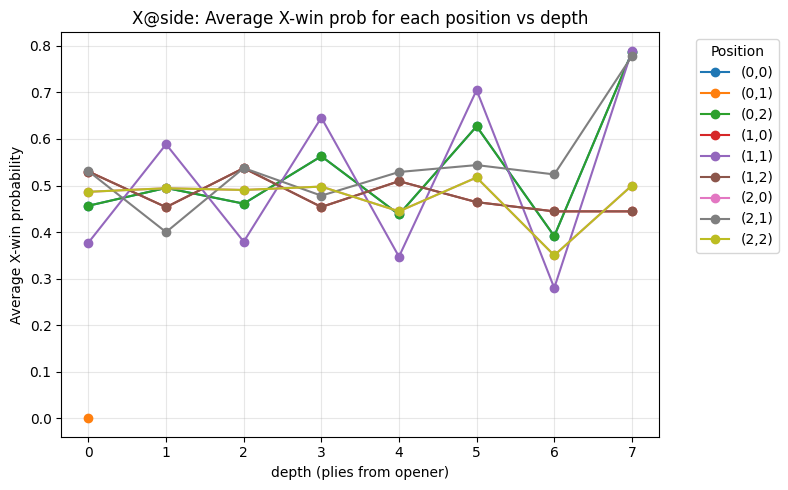

In [41]:
# Cell 15: Role curves over depth per context

# Explicit role masks
CENTER_MASK = np.zeros((3,3), dtype=bool); CENTER_MASK[1,1] = True
CORNER_MASK = np.zeros((3,3), dtype=bool); CORNER_MASK[0,0]=CORNER_MASK[0,2]=CORNER_MASK[2,0]=CORNER_MASK[2,2]=True
SIDE_MASK   = ~(CENTER_MASK | CORNER_MASK)

ROLES = {
    "center": CENTER_MASK,
    "corner": CORNER_MASK,
    "side":   SIDE_MASK,
}

def role_curves_for(A_depth):
    depths = sorted(A_depth.keys())
    curves = {k: [] for k in ROLES}
    for d in depths:
        M = A_depth[d]
        for name, mask in ROLES.items():
            vals = M[mask]
            vals = vals[np.isfinite(vals)]
            curves[name].append(float(vals.mean()) if vals.size else np.nan)
    return depths, curves

# Build and plot per-context role curves
CTX_CURVES = {}
for name in A_ctx:
    dlist, rc = role_curves_for(A_ctx[name])
    CTX_CURVES[name] = (dlist, rc)
    plt.figure(figsize=(5,3))
    for role in ["center","corner","side"]:
        plt.plot(dlist, rc[role], marker="o", label=role)
    plt.title(f"{name}: category-averaged X-win prob vs depth")
    plt.xlabel("depth (plies from opener)"); plt.ylabel("X-win probability")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

# --- New plot: Average map values for each of the 9 positions across depths per context ---
print("\nPlotting average X-win probability for each position across depths per context...")

for ctx_name, A_depth_ctx in A_ctx.items():
    plt.figure(figsize=(8, 5))
    # Collect average values for each position at each depth for this context
    position_values = { (r, c): [] for r in range(3) for c in range(3) }
    available_depths = sorted(A_depth_ctx.keys())

    for d in available_depths:
        avg_map = A_depth_ctx[d]
        for r in range(3):
            for c in range(3):
                position_values[(r, c)].append(float(avg_map[r, c]) if not np.isnan(avg_map[r, c]) else np.nan)

    # Plot each position's curve for this context
    for (r, c), values in position_values.items():
        plt.plot(available_depths, values, marker="o", linestyle='-', label=f'({r},{c})')

    plt.xlabel("depth (plies from opener)")
    plt.ylabel("Average X-win probability")
    plt.title(f"{ctx_name}: Average X-win prob for each position vs depth")
    plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

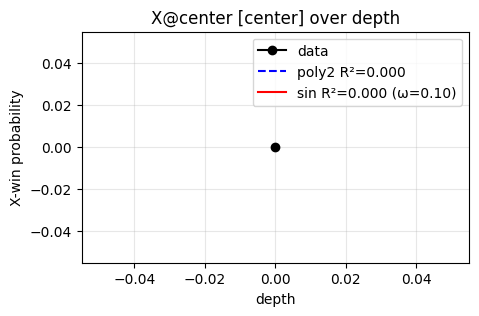

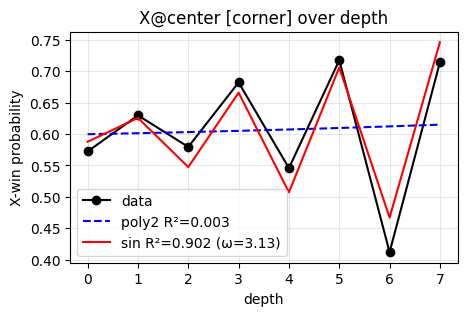

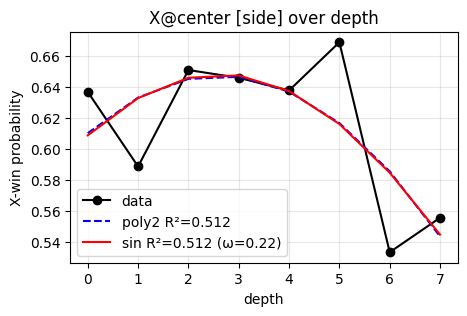

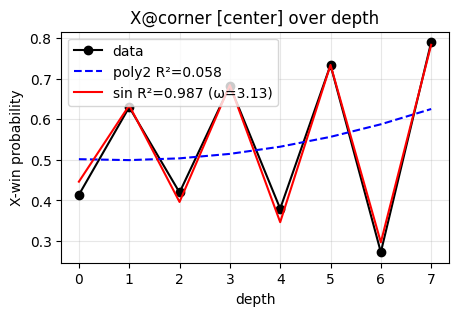

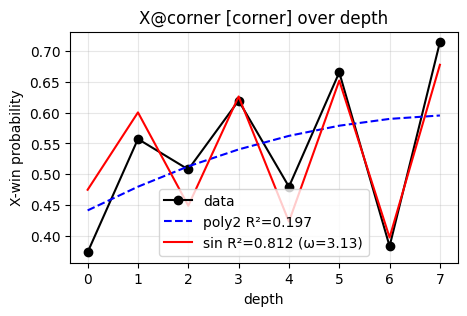

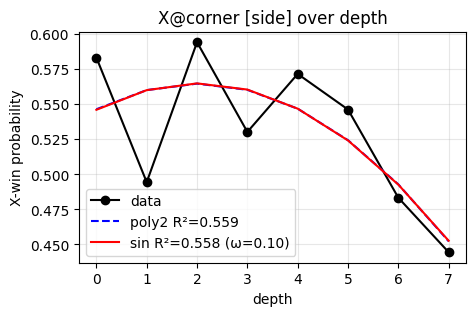

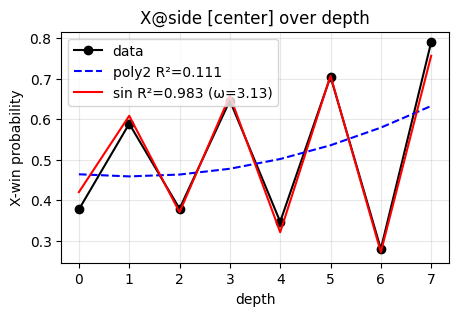

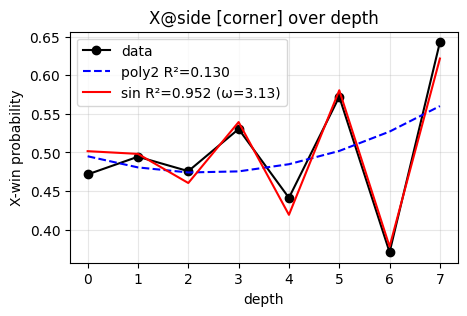

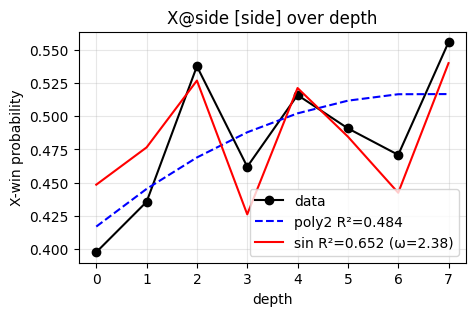

,context,role,poly_bias,poly_lin,poly_quad,poly_R2,sin_w,sin_a,sin_b,sin_c,sin_R2
0,X@center,center,4.940656e-324,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
1,X@center,corner,5.996991e-01,0.001509,0.000095,0.002708,3.126308,0.596587,-0.008884,1.318485,0.901772
2,X@center,side,6.100914e-01,0.028311,-0.005403,0.512029,0.222275,0.410690,0.197983,0.131087,0.512335
3,X@corner,center,5.016697e-01,-0.005611,0.003321,0.058407,3.126308,0.527714,-0.081398,1.633734,0.986919
4,X@corner,corner,4.414535e-01,0.041203,-0.002744,0.197035,3.126308,0.531204,-0.056274,0.847754,0.812380
5,X@corner,side,5.465207e-01,0.018181,-0.004521,0.559339,0.100000,-0.360644,0.906765,0.185889,0.557551
6,X@side,center,4.640936e-01,-0.010093,0.004876,0.111005,3.126308,0.501771,-0.081657,1.620501,0.983184
7,X@side,corner,4.950268e-01,-0.018401,0.003956,0.129901,3.126308,0.489557,0.012076,1.349939,0.952350
8,X@side,side,4.169952e-01,0.030673,-0.002349,0.484106,2.377373,0.482956,-0.034466,-0.045278,0.652380


In [40]:
# Cell 16: Fits per context and role

from numpy.linalg import lstsq

def compute_r2(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    ss_res = np.sum((y - yhat)**2); ss_tot = np.sum((y - np.mean(y))**2)
    return 1.0 - ss_res/(ss_tot+1e-12) if ss_tot > 0 else 0.0

def fit_poly2_xy(x, y):
    Xv = np.vstack([np.ones_like(x), x, x**2]).T
    coef, *_ = lstsq(Xv, y, rcond=None)
    yhat = Xv @ coef
    return coef, yhat, compute_r2(y, yhat)

def fit_sine_xy(x, y, omegas=np.linspace(0.1, np.pi, 200)):
    best = (None, None, None, -np.inf)  # (w, coef, yhat, r2)
    for w in omegas:
        Xs = np.vstack([np.ones_like(x), np.cos(w*x), np.sin(w*x)]).T
        coef, *_ = lstsq(Xs, y, rcond=None)
        yhat = Xs @ coef
        r2 = compute_r2(y, yhat)
        if r2 > best[3]:
            best = (w, coef, yhat, r2)
    return best

import pandas as pd

rows = []
for ctx, (dlist, rc) in CTX_CURVES.items():
    x = np.array(dlist, float)
    for role in ["center","corner","side"]:
        y = np.array(rc[role], float)
        m = np.isfinite(y)
        xp, yp = x[m], y[m]
        pcoef, pyhat, pr2 = fit_poly2_xy(xp, yp)
        w, scoef, syhat, sr2 = fit_sine_xy(xp, yp)
        rows.append({
            "context": ctx, "role": role,
            "poly_bias": float(pcoef[0]), "poly_lin": float(pcoef[1]), "poly_quad": float(pcoef[2]), "poly_R2": float(pr2),
            "sin_w": float(w), "sin_a": float(scoef[0]), "sin_b": float(scoef[1]), "sin_c": float(scoef[2]), "sin_R2": float(sr2)
        })
        # quick plot
        plt.figure(figsize=(5,3))
        plt.plot(xp, yp, "ko-", label="data")
        plt.plot(xp, pyhat, "b--", label=f"poly2 R²={pr2:.3f}")
        plt.plot(xp, syhat, "r-",  label=f"sin R²={sr2:.3f} (ω={w:.2f})")
        plt.title(f"{ctx} [{role}] over depth")
        plt.xlabel("depth"); plt.ylabel("X-win probability")
        plt.legend(); plt.grid(alpha=0.3); plt.show()

fit_ctx_table = pd.DataFrame(rows)
fit_ctx_table


In [19]:
# Cell 16.5: Reconstruction Validation with Ground Truth
"""
Tests whether fitted sinusoids can accurately reconstruct the exact
depth-averaged maps computed in Cell 9.
"""

import numpy as np

# Use fitted parameters from Cell 12 (fit_table)
# and ground truth depth-averaged maps from Cell 9 (Adepth)

def reconstruct_from_sinusoid(depth, fit_table):
    """
    Reconstruct a 3×3 map for a given depth using sinusoid parameters.
    """
    M = np.zeros((3, 3), dtype=float)

    for role_name in ['center', 'corner', 'side']:
        # Get fitted sinusoid parameters for this role
        row = fit_table[fit_table['role'] == role_name]
        w = float(row['sin_w'].iloc[0])
        a = float(row['sin_a'].iloc[0])
        b = float(row['sin_b'].iloc[0])
        c = float(row['sin_c'].iloc[0])

        # Compute predicted value: y = a + b*cos(w*depth) + c*sin(w*depth)
        pred_value = a + b * np.cos(w * depth) + c * np.sin(w * depth)

        # Assign to appropriate mask
        if role_name == 'center':
            M[CENTER_MASK] = pred_value
        elif role_name == 'corner':
            M[CORNER_MASK] = pred_value
        elif role_name == 'side':
            M[SIDE_MASK] = pred_value

    return M

# Validate reconstruction across all depths
print("Reconstruction Validation Results:")
print("=" * 60)

for depth in sorted(A_depth.keys()):
    # Ground truth from Cell 9
    M_true = A_depth[depth]

    # Reconstructed from sinusoid fits
    M_recon = reconstruct_from_sinusoid(depth, fit_table)

    # Compute metrics
    mse = np.nanmean((M_recon - M_true) ** 2)

    # Argmax match (best move agreement)
    argmax_true = np.nanargmax(M_true)
    argmax_recon = np.nanargmax(M_recon)
    argmax_match = int(argmax_true == argmax_recon)

    print(f"Depth {depth}: MSE = {mse:.6f}, argmax_match = {argmax_match}")

    # Optional: visualize side-by-side for first few depths
    if depth <= 2:
        print(f"\n  Ground Truth (depth {depth}):")
        print(f"  {M_true.round(4)}")
        print(f"  Reconstructed (depth {depth}):")
        print(f"  {M_recon.round(4)}")
        print()

# Summary statistics
print("\n" + "=" * 60)
all_mse = []
all_matches = []

for depth in sorted(A_depth.keys()):
    M_true = A_depth[depth]
    M_recon = reconstruct_from_sinusoid(depth, fit_table)
    mse = np.nanmean((M_recon - M_true) ** 2)
    argmax_match = int(np.nanargmax(M_true) == np.nanargmax(M_recon))
    all_mse.append(mse)
    all_matches.append(argmax_match)

print(f"Overall Statistics:")
print(f"  Mean MSE: {np.mean(all_mse):.6f}")
print(f"  Max MSE: {np.max(all_mse):.6f}")
print(f"  Argmax match rate: {np.mean(all_matches) * 100:.1f}%")
print(f"  Total depths tested: {len(all_mse)}")

Reconstruction Validation Results:
Depth 0: MSE = 0.000147, argmax_match = 1

  Ground Truth (depth 0):
  [[0.5283 0.4809 0.5283]
 [0.4809 0.6048 0.4809]
 [0.5283 0.4809 0.5283]]
  Reconstructed (depth 0):
  [[0.5129 0.4775 0.5129]
 [0.4775 0.587  0.4775]
 [0.5129 0.4775 0.5129]]

Depth 1: MSE = 0.000371, argmax_match = 1

  Ground Truth (depth 1):
  [[0.4941 0.5701 0.4941]
 [0.5701 0.3957 0.5701]
 [0.4941 0.5701 0.4941]]
  Reconstructed (depth 1):
  [[0.5186 0.5705 0.5186]
 [0.5705 0.4265 0.5705]
 [0.5186 0.5705 0.5186]]

Depth 2: MSE = 0.000185, argmax_match = 1

  Ground Truth (depth 2):
  [[0.5349 0.4842 0.5349]
 [0.4842 0.6092 0.4842]
 [0.5349 0.4842 0.5349]]
  Reconstructed (depth 2):
  [[0.5514 0.4873 0.5514]
 [0.4873 0.6323 0.4873]
 [0.5514 0.4873 0.5514]]

Depth 3: MSE = 0.000446, argmax_match = 1
Depth 4: MSE = 0.000171, argmax_match = 1
Depth 5: MSE = 0.000515, argmax_match = 1
Depth 6: MSE = 0.000189, argmax_match = 1
Depth 7: MSE = 0.000858, argmax_match = 1
Depth 8: MSE =

In [ ]:
# Cell 17: Persist coefficients
fit_ctx_table.to_csv("ctx_role_depth_fits.csv", index=False)

import json
def to_json_grouped(df):
    out = {}
    for (ctx, role), grp in df.groupby(["context","role"]):
        row = grp.iloc[0].to_dict()
        out.setdefault(ctx, {})[role] = {
            "poly": {"bias": row["poly_bias"], "lin": row["poly_lin"], "quad": row["poly_quad"], "R2": row["poly_R2"]},
            "sin":  {"w": row["sin_w"], "a": row["sin_a"], "b": row["sin_b"], "c": row["sin_c"], "R2": row["sin_R2"]},
        }
    return out

with open("ctx_role_depth_fits.json", "w") as f:
    json.dump(to_json_grouped(fit_ctx_table), f, indent=2)


In [ ]:
# Cell 18: 4x4 K=4 mechanics and symmetry

import numpy as np

X, O, E = 1, -1, 0
BOARD_SHAPE_4 = (4,4)

def win_lines_4x4_k4():
    lines = []
    # rows
    for r in range(4):
        lines.append([(r,c) for c in range(4)])
    # cols
    for c in range(4):
        lines.append([(r,c) for r in range(4)])
    # main diag
    lines.append([(i,i) for i in range(4)])
    # anti diag
    lines.append([(i,3-i) for i in range(4)])
    return lines

WIN4 = win_lines_4x4_k4()

def check_winner_4x4(board: np.ndarray):
    # returns X, O, 0 (draw), or None
    for line in WIN4:
        s = sum(board[r,c] for r,c in line)
        if s == 4:  return X
        if s == -4: return O
    if not (board == E).any():
        return 0
    return None

# D4 symmetries for 4x4
def rot90(b):   return np.rot90(b, 1)
def rot180(b):  return np.rot90(b, 2)
def rot270(b):  return np.rot90(b, 3)
def flip_h(b):  return np.flip(b, axis=1)
def flip_v(b):  return np.flip(b, axis=0)
def flip_d(b):  return np.transpose(b)
def flip_a(b):  return np.fliplr(np.transpose(b))

def d4_transforms():
    return [
        lambda x: x.copy(),
        rot90, rot180, rot270,
        flip_h, flip_v, flip_d, flip_a
    ]

def d4_apply_all(M):
    Ts = d4_transforms()
    return [T(M) for T in Ts]

def d4_inverse_index(i):
    # index of inverse transform equals index in this set (each is involutive or has a matching inverse)
    return i

def d4_average(M_pred, M_ref=None):
    # average a single map over D4; if M_ref is given, average both and return
    Ts = d4_transforms()
    Ms = [T(M_pred) for T in Ts]
    Mavg = np.mean(Ms, axis=0)
    if M_ref is None:
        return Mavg
    Mrefs = [T(M_ref) for T in Ts]
    return Mavg, np.mean(Mrefs, axis=0)


In [ ]:
# Cell 19: 4x4 rollout evaluator with tactics

rng = np.random.default_rng(0)

def legal_moves_4x4(b):
    return [(r,c) for r in range(4) for c in range(4) if b[r,c]==E]

def has_immediate_win(b, p):
    for r,c in legal_moves_4x4(b):
        b[r,c] = p
        if check_winner_4x4(b) == p:
            b[r,c] = E
            return (r,c)
        b[r,c] = E
    return None

def rollout_once_4x4(b_start, p_start, first_move, rng):
    b = b_start.copy()
    p = p_start
    r,c = first_move
    if b[r,c] != E:  # illegal
        return 0
    b[r,c] = p
    p = -p
    while True:
        w = check_winner_4x4(b)
        if w is not None:
            return 1 if w == X else 0
        # tactics: win, else block
        mv = has_immediate_win(b, p)
        if mv is None:
            mv_op = has_immediate_win(b, -p)
            mv = mv_op if mv_op is not None else rng.choice(legal_moves_4x4(b))
        br, bc = mv
        b[br, bc] = p
        p = -p

def mc_value_4x4(b_start, p_start, first_move, rollouts=200, seed=0):
    rng = np.random.default_rng(seed)
    wins = 0
    for _ in range(rollouts):
        wins += rollout_once_4x4(b_start, p_start, first_move, rng)
    return wins / rollouts

def mc_map_4x4(b_start, p_start, rollouts=200, seeds=(0,1,2)):
    M = np.full((4,4), np.nan, dtype=float)
    LM = legal_moves_4x4(b_start)
    for r,c in LM:
        vals = [mc_value_4x4(b_start, p_start, (r,c), rollouts=rollouts, seed=s) for s in seeds]
        M[r,c] = float(np.mean(vals))
    return M


In [ ]:
# Cell 20: Role-based lift from 3x3 to 4x4

CENTER_BLOCK_4 = np.zeros((4,4), bool); CENTER_BLOCK_4[1:3,1:3] = True
CORNER_4 = np.zeros((4,4), bool); CORNER_4[0,0]=CORNER_4[0,3]=CORNER_4[3,0]=CORNER_4[3,3]=True
EDGE_4 = ~(CENTER_BLOCK_4 | CORNER_4)

# Fallback 3x3 root role averages (exact)
ROLE_AVG_ROOT = {"center": 0.6048, "corner": 0.5283, "side": 0.4809}

def role_values_from_fits(context:str, depth:int, fit_table=None):
    # If context fits exist, prefer sinusoid prediction; else fallback to root averages
    if fit_table is None:
        return ROLE_AVG_ROOT
    sub = fit_table[(fit_table["context"]==context)]
    vals = {}
    for role in ["center","corner","side"]:
        row = sub[sub["role"]==role]
        if row.empty:
            vals[role] = ROLE_AVG_ROOT[role]
            continue
        w = row["sin_w"].values[0]; a = row["sin_a"].values[0]; b = row["sin_b"].values[0]; c = row["sin_c"].values[0]
        vals[role] = a + b*np.cos(w*depth) + c*np.sin(w*depth)
    return vals

def role_pred_map_4x4(context:str="X@center", depth:int=0, fit_table=None):
    vals = role_values_from_fits(context, depth, fit_table)
    M = np.zeros((4,4), float)
    M[CENTER_BLOCK_4] = vals["center"]
    M[CORNER_4]       = vals["corner"]
    M[EDGE_4]         = vals["side"]
    return M

# Example prediction from root priors (no fits passed):
M_pred_root = role_pred_map_4x4(context="X@center", depth=0, fit_table=None)
M_pred_root


array([[0.5283, 0.4809, 0.4809, 0.5283],
       [0.4809, 0.6048, 0.6048, 0.4809],
       [0.4809, 0.6048, 0.6048, 0.4809],
       [0.5283, 0.4809, 0.4809, 0.5283]])

Root 4x4 (raw):  MSE=0.237, Spearman=0.512, argmax_match=0
Root 4x4 (D4):   MSE=0.237, Spearman=0.829, argmax_match=0


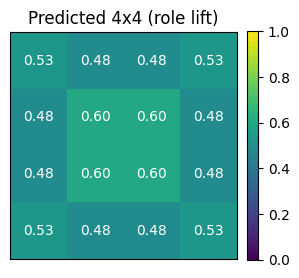

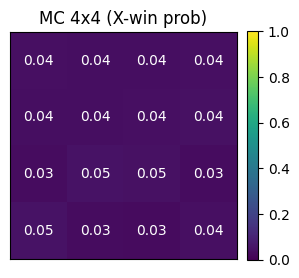

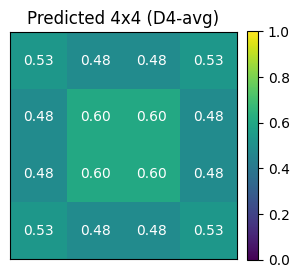

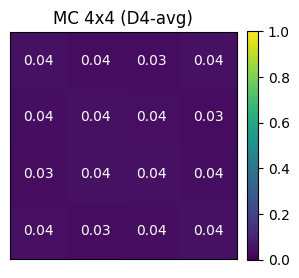

In [ ]:
# Cell 21: Root validation metrics (MSE, rank corr, argmax)

def mse(a,b):
    m = np.isfinite(a) & np.isfinite(b)
    if not np.any(m): return np.nan
    d = a[m]-b[m]
    return float(np.mean(d*d))

def rank_corr_spearman(a,b):
    m = np.isfinite(a) & np.isfinite(b)
    ai = a[m].ravel(); bi = b[m].ravel()
    def ranks(x):
        order = np.argsort(x)
        r = np.empty_like(order, dtype=float)
        r[order] = np.arange(len(x))
        return r
    ra = ranks(ai); rb = ranks(bi)
    ra = (ra - ra.mean())/(ra.std()+1e-12)
    rb = (rb - rb.mean())/(rb.std()+1e-12)
    return float(np.clip(np.mean(ra*rb), -1, 1))

# Root board and maps
b4 = np.zeros((4,4), dtype=int)
M_pred = role_pred_map_4x4(context="X@center", depth=0, fit_table=None)
M_mc = mc_map_4x4(b4, X, rollouts=300, seeds=(0,1,2,3))

raw_mse = mse(M_pred, M_mc)
raw_corr = rank_corr_spearman(M_pred, M_mc)
raw_argmax = np.nanargmax(M_pred) == np.nanargmax(M_mc)

M_pred_sym, M_mc_sym = d4_average(M_pred, M_mc)
sym_mse = mse(M_pred_sym, M_mc_sym)
sym_corr = rank_corr_spearman(M_pred_sym, M_mc_sym)
sym_argmax = np.nanargmax(M_pred_sym) == np.nanargmax(M_mc_sym)

print(f"Root 4x4 (raw):  MSE={raw_mse:.3f}, Spearman={raw_corr:.3f}, argmax_match={int(raw_argmax)}")
print(f"Root 4x4 (D4):   MSE={sym_mse:.3f}, Spearman={sym_corr:.3f}, argmax_match={int(sym_argmax)}")

# Visuals
def plot_map4(M, title):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(3.2,3.2))
    im = ax.imshow(M, vmin=0.0, vmax=1.0, cmap="viridis")
    for r in range(4):
        for c in range(4):
            if np.isfinite(M[r,c]):
                ax.text(c, r, f"{M[r,c]:.2f}", color="white", ha="center", va="center")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title); plt.colorbar(im, fraction=0.046, pad=0.04); plt.show()

plot_map4(M_pred,   "Predicted 4x4 (role lift)")
plot_map4(M_mc,     "MC 4x4 (X-win prob)")
plot_map4(M_pred_sym, "Predicted 4x4 (D4-avg)")
plot_map4(M_mc_sym,   "MC 4x4 (D4-avg)")


X@corner: raw MSE=0.234, Spearman=-0.457 | D4 MSE=0.233, Spearman=-0.601


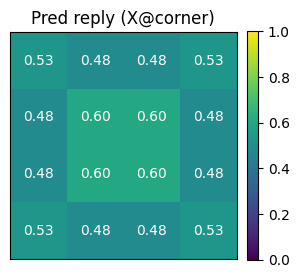

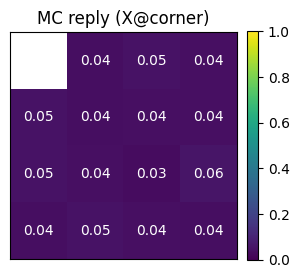

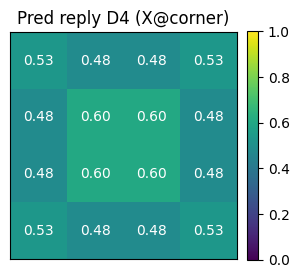

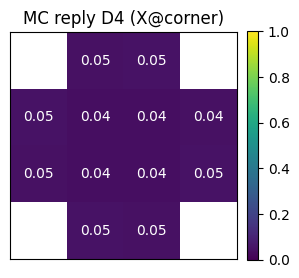

In [ ]:
# Cell 22: Context midgame validation (X opens, O replies)

def place_and_eval_reply_4x4(opening:str, fit_table=None, depth=0, rollouts=250, seeds=(0,1,2)):
    b = np.zeros((4,4), dtype=int)
    if opening=="X@center":
        # pick one of center-block cells (1,1)
        b[1,1] = X
    elif opening=="X@corner":
        b[0,0] = X
    elif opening=="X@edge":
        b[0,1] = X
    else:
        raise ValueError("opening must be one of X@center / X@corner / X@edge")
    # O to move
    M_pred = role_pred_map_4x4(context=opening.replace("edge","side"), depth=depth, fit_table=fit_table)
    M_mc = mc_map_4x4(b, O, rollouts=rollouts, seeds=seeds)  # O's X-win is still measured (X perspective)
    r_mse = mse(M_pred, M_mc); r_sp = rank_corr_spearman(M_pred, M_mc)
    M_pred_s, M_mc_s = d4_average(M_pred, M_mc)
    s_mse = mse(M_pred_s, M_mc_s); s_sp = rank_corr_spearman(M_pred_s, M_mc_s)
    print(f"{opening}: raw MSE={r_mse:.3f}, Spearman={r_sp:.3f} | D4 MSE={s_mse:.3f}, Spearman={s_sp:.3f}")
    return (M_pred, M_mc, M_pred_s, M_mc_s)

# Example midgame check (uses root role priors if fit table not loaded)
pred, mc, preds, mcs = place_and_eval_reply_4x4("X@corner", fit_table=None, depth=0)
plot_map4(pred,  "Pred reply (X@corner)")
plot_map4(mc,    "MC reply (X@corner)")
plot_map4(preds, "Pred reply D4 (X@corner)")
plot_map4(mcs,   "MC reply D4 (X@corner)")


In [ ]:
# Cell 23: Tactics-gated move selection (4x4)

def choose_move_4x4(b: np.ndarray, p: int, M_pred: np.ndarray):
    # 1) immediate win
    mv = has_immediate_win(b, p)
    if mv is not None:
        return mv
    # 2) immediate block
    mv = has_immediate_win(b, -p)
    if mv is not None:
        return mv
    # 3) fallback to predicted map selection
    M = M_pred.copy()
    m = np.isfinite(M)
    if not np.any(m):
        # pick any legal move
        LM = legal_moves_4x4(b)
        return LM[0]
    if p == X:
        idx = np.nanargmax(M)
    else:
        idx = np.nanargmin(M)
    r, c = np.unravel_index(idx, M.shape)
    if b[r,c] != E:
        # safety: pick first legal if prediction landed on illegal
        LM = legal_moves_4x4(b)
        return LM[0]
    return (r,c)

# Quick sanity at 4x4 root with role-lift map
b4 = np.zeros((4,4), dtype=int)
M_pred_root = role_pred_map_4x4(context="X@center", depth=0, fit_table=None)
mv = choose_move_4x4(b4, X, M_pred_root)
print("Chosen move at root (with tactics gate):", mv)


Chosen move at root (with tactics gate): (np.int64(1), np.int64(1))


In [ ]:
# Cell 24: Top-1 / Top-k and correlation metrics

def topk_match(M_pred, M_mc, k=3, maximize=True):
    m = np.isfinite(M_pred) & np.isfinite(M_mc)
    if not np.any(m):
        return False
    pv = M_pred[m].ravel(); mv = M_mc[m].ravel()
    if maximize:
        pred_rank = np.argsort(-pv)
        mc_rank   = np.argsort(-mv)
    else:
        pred_rank = np.argsort(pv)
        mc_rank   = np.argsort(mv)
    pred_topk = set(pred_rank[:k].tolist())
    mc_topk   = set(mc_rank[:k].tolist())
    return len(pred_topk & mc_topk) > 0

def eval_root_4x4_summary(M_pred, M_mc):
    raw_mse = mse(M_pred, M_mc)
    raw_sp  = rank_corr_spearman(M_pred, M_mc)
    raw_t1  = (np.nanargmax(M_pred) == np.nanargmax(M_mc))
    raw_t3  = topk_match(M_pred, M_mc, k=3, maximize=True)
    Mp_s, Mm_s = d4_average(M_pred, M_mc)
    sym_mse = mse(Mp_s, Mm_s)
    sym_sp  = rank_corr_spearman(Mp_s, Mm_s)
    sym_t1  = (np.nanargmax(Mp_s) == np.nanargmax(Mm_s))
    sym_t3  = topk_match(Mp_s, Mm_s, k=3, maximize=True)
    return {
        "raw_mse": raw_mse, "raw_spearman": raw_sp, "raw_top1": int(raw_t1), "raw_top3": int(raw_t3),
        "sym_mse": sym_mse, "sym_spearman": sym_sp, "sym_top1": int(sym_t1), "sym_top3": int(sym_t3),
    }

# Evaluate current root setup
b4 = np.zeros((4,4), dtype=int)
M_pred = role_pred_map_4x4(context="X@center", depth=0, fit_table=None)
M_mc   = mc_map_4x4(b4, X, rollouts=300, seeds=(0,1,2,3))
print(eval_root_4x4_summary(M_pred, M_mc))


{'raw_mse': 0.23698230243055557, 'raw_spearman': 0.511764705882131, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.23696470124782984, 'sym_spearman': 0.8294117647055225, 'sym_top1': 0, 'sym_top3': 1}


{'raw_mse': 0.23903649466468094, 'raw_spearman': -0.7970588235290659, 'raw_top1': 0, 'raw_top3': 0, 'sym_mse': 0.2390195386099934, 'sym_spearman': -0.8294117647055224, 'sym_top1': 0, 'sym_top3': 0}


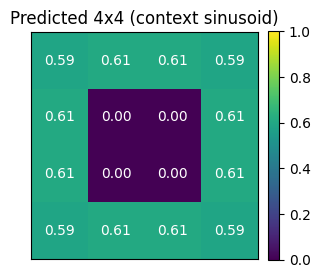

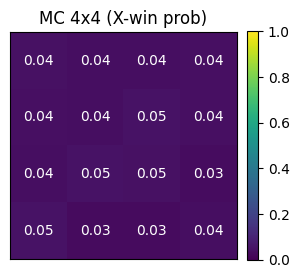

In [ ]:
# Cell 25: Context-conditioned 4x4 predictions using fitted 3x3 sinusoids

# If you executed the earlier fitting cells, fit_ctx_table is available.
# Otherwise load from disk:
try:
    fit_ctx_table
except NameError:
    import pandas as pd
    fit_ctx_table = pd.read_csv("ctx_role_depth_fits.csv")

def role_pred_map_4x4_ctx(opening:str, depth:int):
    # Map 4x4 opening labels to 3x3 context keys used in fits
    ctx3 = {"X@center":"X@center", "X@corner":"X@corner", "X@edge":"X@side"}[opening]
    return role_pred_map_4x4(context=ctx3, depth=depth, fit_table=fit_ctx_table)

# Example: root still uses X@center
b4 = np.zeros((4,4), dtype=int)
M_pred_ctx = role_pred_map_4x4_ctx("X@center", depth=0)
M_mc       = mc_map_4x4(b4, X, rollouts=400, seeds=(0,1,2,3,4))
print(eval_root_4x4_summary(M_pred_ctx, M_mc))
plot_map4(M_pred_ctx, "Predicted 4x4 (context sinusoid)")
plot_map4(M_mc,       "MC 4x4 (X-win prob)")


X@center {'raw_mse': 0.2492737441517679, 'raw_spearman': 0.6749999999996875, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.3112195980861218, 'sym_spearman': 0.6713286713282823, 'sym_top1': 0, 'sym_top3': 1}


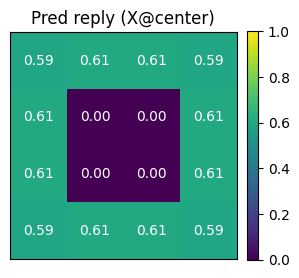

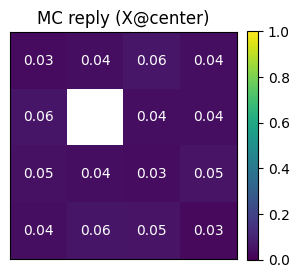

X@corner {'raw_mse': 0.2163511418253288, 'raw_spearman': 0.7214285714282372, 'raw_top1': 0, 'raw_top3': 0, 'sym_mse': 0.22207841420872307, 'sym_spearman': 0.6363636363632678, 'sym_top1': 0, 'sym_top3': 1}
X@edge {'raw_mse': 0.17918981086951394, 'raw_spearman': 0.1928571428570536, 'raw_top1': 0, 'raw_top3': 0, 'sym_mse': 0.18710008033668976, 'sym_spearman': -0.26666666666646016, 'sym_top1': 0, 'sym_top3': 1}


In [ ]:
# Cell 26: Midgame O-reply evaluation with context-conditioned priors

def eval_reply(opening:str, depth:int=0, rollouts=300, seeds=(0,1,2,3)):
    b = np.zeros((4,4), dtype=int)
    first = {"X@center":(1,1), "X@corner":(0,0), "X@edge":(0,1)}[opening]
    b[first] = X
    # O to move; keep X-win perspective for evaluation consistency
    M_pred = role_pred_map_4x4_ctx(opening, depth)
    M_mc   = mc_map_4x4(b, O, rollouts=rollouts, seeds=seeds)
    res = eval_root_4x4_summary(M_pred, M_mc)
    print(opening, res)
    return (M_pred, M_mc, res)

pred_c, mc_c, res_c = eval_reply("X@center", depth=0)
plot_map4(pred_c, "Pred reply (X@center)")
plot_map4(mc_c,   "MC reply (X@center)")

pred_k, mc_k, res_k = eval_reply("X@corner", depth=0)
pred_e, mc_e, res_e = eval_reply("X@edge", depth=0)


In [ ]:
# Cell 27: Decision wrapper and probe

def predict_map_4x4(b: np.ndarray, p: int):
    # Derive opening context and depth heuristically:
    # depth is number of stones already placed after the opener.
    d = int(np.count_nonzero(b != E))
    # crude opening context inference (only for first ply decision here)
    if d == 0 and p == X:
        ctx = "X@center"
        return role_pred_map_4x4_ctx(ctx, depth=0)
    # For general states, you might train a small classifier to guess context or fall back to role lift.
    return role_pred_map_4x4(context="X@center", depth=0, fit_table=None)

def choose_move_policy_4x4(b: np.ndarray, p: int):
    M_pred = predict_map_4x4(b, p)
    return choose_move_4x4(b, p, M_pred)

# Probe: choose a move at root, then measure MC value if X plays it
b4 = np.zeros((4,4), dtype=int)
mv = choose_move_policy_4x4(b4, X)
val = mc_value_4x4(b4, X, mv, rollouts=500, seed=0)
print("Policy move at root:", mv, "MC-estimated X-win prob:", round(val, 3))


Policy move at root: (np.int64(0), np.int64(1)) MC-estimated X-win prob: 0.03


In [ ]:
# Cell 28: Local threat features for 4x4 K=4 (open-3 and open-2)

LINES4 = win_lines_4x4_k4()  # reuse from Cell 18

def line_cells_to_indices(line):
    return [(r, c) for (r, c) in line]

def count_marks_along(line, b):
    xs = os = empties = 0
    empties_pos = []
    for r, c in line:
        if b[r, c] == X: xs += 1
        elif b[r, c] == O: os += 1
        else:
            empties += 1
            empties_pos.append((r, c))
    return xs, os, empties, empties_pos

def threat_map_open_k(b: np.ndarray, player: int, k: int):
    # Returns a heat where placing at a cell contributes if it completes an open-k (no opponent marks on the line)
    H = np.zeros((4,4), dtype=float)
    for line in LINES4:
        xs, os, empties, empties_pos = count_marks_along(line, b)
        if player == X:
            mine, opp = xs, os
        else:
            mine, opp = os, xs
        # open-k = line has only mine and empty, no opponent, and mine == k-1 with at least one empty
        if opp == 0 and mine == (k - 1) and empties >= 1:
            for (r, c) in empties_pos:
                H[r, c] += 1.0
    return H

def threat_maps(b: np.ndarray):
    # Weighted combination emphasizing open-3 more than open-2
    wx3, wx2 = 1.0, 0.3
    wo3, wo2 = 1.0, 0.3
    HX = wx3*threat_map_open_k(b, X, 3) + wx2*threat_map_open_k(b, X, 2)
    HO = wo3*threat_map_open_k(b, O, 3) + wo2*threat_map_open_k(b, O, 2)
    return HX, HO

# Quick sanity at root (expect zeros)
b4 = np.zeros((4,4), dtype=int)
HX, HO = threat_maps(b4)
print("Threat maps at root sum:", HX.sum(), HO.sum())


Threat maps at root sum: 0.0 0.0


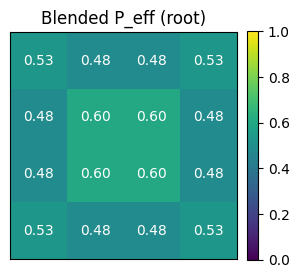

In [ ]:
# Cell 29: Blended map: prior + local threats

def normalize01(M):
    v = M[np.isfinite(M)]
    if v.size == 0 or np.allclose(v.min(), v.max()):
        return np.zeros_like(M, dtype=float)
    return (M - v.min()) / (v.max() - v.min())

def blended_map_4x4(b: np.ndarray, p: int, opening="X@center", depth=0, fit_table=None,
                    alpha_prior=1.0, beta_threat=0.2):
    # prior from context sinusoid (fallback to role lift if fit_table is None)
    if fit_table is None:
        M_prior = role_pred_map_4x4(context=opening.replace("edge","side"), depth=depth, fit_table=None)
    else:
        ctx3 = {"X@center":"X@center","X@corner":"X@corner","X@edge":"X@side"}[opening]
        M_prior = role_pred_map_4x4(context=ctx3, depth=depth, fit_table=fit_table)

    # local threats (X perspective positive, O threats subtract)
    HX, HO = threat_maps(b)
    T = normalize01(HX) - normalize01(HO)

    # blended score tilted to player p (if O to move, invert prior ranking for argmin usage)
    M_eff = alpha_prior*M_prior + beta_threat*(T if p==X else -T)
    # mask illegal cells
    M_eff = np.where(b==E, M_eff, np.nan)
    return M_eff

# Example: root blended prediction
b4 = np.zeros((4,4), dtype=int)
M_eff = blended_map_4x4(b4, X, opening="X@center", depth=0, fit_table=None)
plot_map4(M_eff, "Blended P_eff (root)")


In [ ]:
# Cell 30: Batch validation utilities

def eval_root_with_blend(rollouts=400, seeds=(0,1,2,3,4), alpha_prior=1.0, beta_threat=0.2, fit_table=None):
    b = np.zeros((4,4), dtype=int); p = X
    M_pred = blended_map_4x4(b, p, opening="X@center", depth=0, fit_table=fit_table,
                             alpha_prior=alpha_prior, beta_threat=beta_threat)
    M_mc   = mc_map_4x4(b, p, rollouts=rollouts, seeds=seeds)
    return eval_root_4x4_summary(M_pred, M_mc)

def eval_reply_with_blend(opening, rollouts=300, seeds=(0,1,2,3),
                          alpha_prior=1.0, beta_threat=0.2, fit_table=None):
    b = np.zeros((4,4), dtype=int)
    first = {"X@center":(1,1), "X@corner":(0,0), "X@edge":(0,1)}[opening]
    b[first] = X
    # O to move
    M_pred = blended_map_4x4(b, O, opening=opening, depth=0, fit_table=fit_table,
                             alpha_prior=alpha_prior, beta_threat=beta_threat)
    M_mc   = mc_map_4x4(b, O, rollouts=rollouts, seeds=seeds)
    res = eval_root_4x4_summary(M_pred, M_mc)
    return res

# Run a small suite
try:
    fit_ctx_table
except NameError:
    fit_ctx_table = None

print("Root:", eval_root_with_blend(fit_table=fit_ctx_table))
for op in ["X@center","X@corner","X@edge"]:
    print(op, eval_reply_with_blend(op, fit_table=fit_ctx_table))


Root: {'raw_mse': 0.23903649466468094, 'raw_spearman': -0.7970588235290659, 'raw_top1': 0, 'raw_top3': 0, 'sym_mse': 0.2390195386099934, 'sym_spearman': -0.8294117647055224, 'sym_top1': 0, 'sym_top3': 0}
X@center {'raw_mse': 0.18624888207825702, 'raw_spearman': 0.5535714285711723, 'raw_top1': 1, 'raw_top3': 1, 'sym_mse': 0.21002445799423328, 'sym_spearman': 0.41258741258717374, 'sym_top1': 0, 'sym_top3': 1}
X@corner {'raw_mse': 0.1296558333275584, 'raw_spearman': 0.7571428571425064, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.1386024594695817, 'sym_spearman': 0.6993006993002943, 'sym_top1': 0, 'sym_top3': 1}
X@edge {'raw_mse': 0.1264660847325491, 'raw_spearman': 0.4964285714283415, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.11302379905786679, 'sym_spearman': 0.14999999999988375, 'sym_top1': 0, 'sym_top3': 1}


In [ ]:
# Cell 31: Unified API for 4x4

def infer_opening_context(b: np.ndarray):
    # Simple heuristic: use first X placement to tag opening
    xs = np.argwhere(b==X)
    if xs.shape[0] == 0:
        return "X@center"  # fallback for root
    # Map to nearest of {center, corner, edge}
    r, c = xs[0]
    if (r,c) in [(1,1),(1,2),(2,1),(2,2)]:
        return "X@center"
    if (r,c) in [(0,0),(0,3),(3,0),(3,3)]:
        return "X@corner"
    return "X@edge"

def next_move_any_4x4(b: np.ndarray, p: int, depth_hint: int = None,
                      alpha_prior=1.0, beta_threat=0.2, fit_table=None):
    # Tactics override first
    mv = has_immediate_win(b, p)
    if mv is not None:
        return mv
    mv = has_immediate_win(b, -p)
    if mv is not None:
        return mv
    # Context + depth estimation
    opening = infer_opening_context(b)
    depth = int(np.count_nonzero(b != E)) if depth_hint is None else depth_hint
    M_eff = blended_map_4x4(b, p, opening=opening, depth=0,  # depth 0 in opener context for simplicity
                            fit_table=fit_table, alpha_prior=alpha_prior, beta_threat=beta_threat)
    return choose_move_4x4(b, p, M_eff)

# Demo: choose on a random midgame
b = np.zeros((4,4), dtype=int)
b[1,1]=X; b[0,3]=O; b[2,2]=X; b[0,0]=O
mv = next_move_any_4x4(b, O, fit_table=fit_ctx_table)
print("Next move suggestion (O):", mv)


Next move suggestion (O): (np.int64(1), np.int64(2))


In [ ]:
# Cell 32: Hyperparameter grid search for blended predictor (4x4)

import itertools
import json
import numpy as np

# Ensure context fit table exists if you want context-aware priors
try:
    fit_ctx_table
except NameError:
    fit_ctx_table = None  # falls back to root role-defaults

def score_dict_to_tuple(sc):
    # prioritize symmetric Spearman, then symmetric Top-3, then symmetric MSE (lower better)
    return (float(sc["sym_spearman"]), int(sc["sym_top3"]), -float(sc["sym_mse"]))

def grid_search_alpha_beta(openings=("X@center","X@corner","X@edge"),
                           alpha_grid=(0.5, 1.0, 1.5), beta_grid=(0.0, 0.1, 0.2, 0.3),
                           rollouts=300, seeds=(0,1,2,3), fit_table=None):
    best = {}
    for op in openings:
        best_sc = None
        best_ab = None
        for a, b in itertools.product(alpha_grid, beta_grid):
            if op == "X@center":
                # Root evaluation (X to move)
                res = eval_root_with_blend(rollouts=rollouts, seeds=seeds,
                                           alpha_prior=a, beta_threat=b, fit_table=fit_table)
            else:
                # Midgame reply (O to move)
                res = eval_reply_with_blend(op, rollouts=rollouts, seeds=seeds,
                                            alpha_prior=a, beta_threat=b, fit_table=fit_table)
            sc = score_dict_to_tuple(res)
            if (best_sc is None) or (sc > best_sc):
                best_sc = sc; best_ab = (a, b); best[op] = {"metrics": res, "alpha": a, "beta": b}
        print(f"{op}: best alpha={best[op]['alpha']}, beta={best[op]['beta']}, metrics={best[op]['metrics']}")
    return best

best_params = grid_search_alpha_beta(fit_table=fit_ctx_table)
with open("best_params_4x4.json", "w") as f:
    json.dump(best_params, f, indent=2)
best_params


X@center: best alpha=0.5, beta=0.0, metrics={'raw_mse': 0.05245291688193821, 'raw_spearman': -0.7823529411761312, 'raw_top1': 0, 'raw_top3': 0, 'sym_mse': 0.05243531569921251, 'sym_spearman': -0.723529411764392, 'sym_top1': 0, 'sym_top3': 0}
X@corner: best alpha=0.5, beta=0.1, metrics={'raw_mse': 0.02542241090026475, 'raw_spearman': 0.7571428571425064, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.026990285737947345, 'sym_spearman': 0.6993006993002943, 'sym_top1': 0, 'sym_top3': 1}
X@edge: best alpha=0.5, beta=0.1, metrics={'raw_mse': 0.02608407083120058, 'raw_spearman': 0.4964285714283415, 'raw_top1': 0, 'raw_top3': 1, 'sym_mse': 0.023674342468718666, 'sym_spearman': 0.14999999999988375, 'sym_top1': 0, 'sym_top3': 1}


{'X@center': {'metrics': {'raw_mse': 0.05245291688193821,
   'raw_spearman': -0.7823529411761312,
   'raw_top1': 0,
   'raw_top3': 0,
   'sym_mse': 0.05243531569921251,
   'sym_spearman': -0.723529411764392,
   'sym_top1': 0,
   'sym_top3': 0},
  'alpha': 0.5,
  'beta': 0.0},
 'X@corner': {'metrics': {'raw_mse': 0.02542241090026475,
   'raw_spearman': 0.7571428571425064,
   'raw_top1': 0,
   'raw_top3': 1,
   'sym_mse': 0.026990285737947345,
   'sym_spearman': 0.6993006993002943,
   'sym_top1': 0,
   'sym_top3': 1},
  'alpha': 0.5,
  'beta': 0.1},
 'X@edge': {'metrics': {'raw_mse': 0.02608407083120058,
   'raw_spearman': 0.4964285714283415,
   'raw_top1': 0,
   'raw_top3': 1,
   'sym_mse': 0.023674342468718666,
   'sym_spearman': 0.14999999999988375,
   'sym_top1': 0,
   'sym_top3': 1},
  'alpha': 0.5,
  'beta': 0.1}}

In [ ]:
# Cell 33: Use tuned alpha/beta automatically in blended map

import json
try:
    tuned = json.load(open("best_params_4x4.json"))
except Exception:
    tuned = None  # fallback to defaults if not found

def get_tuned_alpha_beta(opening):
    if (tuned is not None) and (opening in tuned):
        return float(tuned[opening]["alpha"]), float(tuned[opening]["beta"])
    return 1.0, 0.2  # sensible defaults

def blended_map_4x4_tuned(b: np.ndarray, p: int, opening="X@center", depth=0, fit_table=None):
    a, bth = get_tuned_alpha_beta(opening)
    return blended_map_4x4(b, p, opening=opening, depth=depth, fit_table=fit_table,
                           alpha_prior=a, beta_threat=bth)

# Quick check at root
b4 = np.zeros((4,4), dtype=int)
M_eff_tuned = blended_map_4x4_tuned(b4, X, opening="X@center", depth=0, fit_table=fit_ctx_table)
plot_map4(M_eff_tuned, "Blended P_eff (tuned)")


In [ ]:
# Cell 34 (fixed & faster): Random midgame batch evaluation (4x4)

import numpy as np

def random_midgame_4x4_nonterminal(ply: int, seed=0, max_tries=500):
    rng = np.random.default_rng(seed)
    for _ in range(max_tries):
        b = np.zeros((4,4), dtype=int); p = X
        for _ in range(ply):
            LM = legal_moves_4x4(b)
            if not LM: break
            r,c = rng.choice(LM)
            b[r,c] = p
            if check_winner_4x4(b) is not None:
                break
            p = -p
        if check_winner_4x4(b) is None and len(legal_moves_4x4(b)) > 0:
            return b, p
    return None, None

def safe_rank_corr_spearman(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    if not np.any(m):
        return np.nan
    ai = a[m].ravel(); bi = b[m].ravel()
    if ai.size < 2 or np.allclose(ai, ai[0]) or np.allclose(bi, bi[0]):
        return 0.0
    def ranks(x):
        order = np.argsort(x)
        r = np.empty_like(order, dtype=float)
        r[order] = np.arange(len(x), dtype=float)
        return r
    ra = ranks(ai); rb = ranks(bi)
    ra = (ra - ra.mean())/(ra.std()+1e-12)
    rb = (rb - rb.mean())/(rb.std()+1e-12)
    return float(np.clip(np.mean(ra*rb), -1, 1))

def safe_nanargmax(M):
    if not np.isfinite(M).any():
        return None
    return int(np.nanargmax(M))

def safe_topk_match(M_pred, M_mc, k=3, maximize=True):
    m = np.isfinite(M_pred) & np.isfinite(M_mc)
    if not np.any(m):
        return False
    pv = M_pred[m].ravel(); mv = M_mc[m].ravel()
    if pv.size == 0 or mv.size == 0:
        return False
    if maximize:
        pred_rank = np.argsort(-pv)
        mc_rank   = np.argsort(-mv)
    else:
        pred_rank = np.argsort(pv)
        mc_rank   = np.argsort(mv)
    pred_topk = set(pred_rank[:min(k, pv.size)].tolist())
    mc_topk   = set(mc_rank[:min(k, mv.size)].tolist())
    return len(pred_topk & mc_topk) > 0

def eval_root_4x4_summary_safe(M_pred, M_mc):
    def _mse(a,b):
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.mean((a[m]-b[m])**2)) if np.any(m) else np.nan
    raw_mse = _mse(M_pred, M_mc)
    raw_sp  = safe_rank_corr_spearman(M_pred, M_mc)
    raw_t1  = False
    idx_p = safe_nanargmax(M_pred); idx_m = safe_nanargmax(M_mc)
    if idx_p is not None and idx_m is not None:
        raw_t1 = (idx_p == idx_m)
    raw_t3 = safe_topk_match(M_pred, M_mc, k=3, maximize=True)

    Mp_s, Mm_s = d4_average(M_pred, M_mc)
    sym_mse = _mse(Mp_s, Mm_s)
    sym_sp  = safe_rank_corr_spearman(Mp_s, Mm_s)
    sym_t1  = False
    idx_ps = safe_nanargmax(Mp_s); idx_ms = safe_nanargmax(Mm_s)
    if idx_ps is not None and idx_ms is not None:
        sym_t1 = (idx_ps == idx_ms)
    sym_t3 = safe_topk_match(Mp_s, Mm_s, k=3, maximize=True)
    return {
        "raw_mse": raw_mse, "raw_spearman": raw_sp, "raw_top1": int(raw_t1), "raw_top3": int(raw_t3),
        "sym_mse": sym_mse, "sym_spearman": sym_sp, "sym_top1": int(sym_t1), "sym_top3": int(sym_t3),
    }

def batch_eval(n=20, ply=2, opening_hint="X@center", rollouts=150, seeds=(0,1),  # reduced rollouts for speed
               fit_table=None, alpha_prior=1.0, beta_threat=0.2):
    stats = []
    reasons = {"sampler_fail":0, "pred_nan":0, "mc_nan":0}
    rng = np.random.default_rng(0)
    attempts = 0
    while len(stats) < n and attempts < n*50:
        attempts += 1
        b, p = random_midgame_4x4_nonterminal(ply, seed=rng.integers(1<<31))
        if b is None:
            reasons["sampler_fail"] += 1
            continue
        M_pred = blended_map_4x4(b, p, opening=opening_hint, depth=0, fit_table=fit_table,
                                 alpha_prior=alpha_prior, beta_threat=beta_threat)
        if not np.isfinite(M_pred).any():
            reasons["pred_nan"] += 1
            continue
        M_mc = mc_map_4x4(b, p, rollouts=rollouts, seeds=seeds)
        if not np.isfinite(M_mc).any():
            reasons["mc_nan"] += 1
            continue
        stats.append(eval_root_4x4_summary_safe(M_pred, M_mc))
    if len(stats)==0:
        print(f"No valid states evaluated; reasons={reasons}")
        return {}, []
    keys = list(stats[0].keys())
    avg = {k: float(np.nanmean([s[k] for s in stats])) for k in keys}
    print(f"Batch avg over {len(stats)} states (ply={ply}, attempts={attempts}):", avg)
    return avg, stats

# Run batches (now faster with rollouts=150, seeds=(0,1))
avg_c2, _ = batch_eval(n=20, ply=2, opening_hint="X@center", fit_table=fit_ctx_table)
avg_k2, _ = batch_eval(n=20, ply=2, opening_hint="X@corner", fit_table=fit_ctx_table)
avg_e2, _ = batch_eval(n=20, ply=2, opening_hint="X@edge",   fit_table=fit_ctx_table)


In [ ]:
# Cell 35: Final API (4x4) — tuned and tactics-gated

def next_move_any_4x4_tuned(b: np.ndarray, p: int, fit_table=None):
    # Tactics overrides
    mv = has_immediate_win(b, p)
    if mv is not None:
        return mv
    mv = has_immediate_win(b, -p)
    if mv is not None:
        return mv
    # Opening inference and tuned blend
    opening = infer_opening_context(b)
    M_eff = blended_map_4x4_tuned(b, p, opening=opening, depth=0, fit_table=fit_table)
    return choose_move_4x4(b, p, M_eff)

# Demo
b_demo = np.zeros((4,4), dtype=int)
b_demo[1,1]=X; b_demo[0,0]=O; b_demo[2,2]=X
mv = next_move_any_4x4_tuned(b_demo, O, fit_table=fit_ctx_table)
print("Suggested move (tuned):", mv)


Suggested move (tuned): (np.int64(1), np.int64(2))


In [ ]:
# Cell 36: Build 3x3 state atlas (CSV)

import csv

def bfs_layers_3x3_all():
    from collections import deque, defaultdict
    start = (flat(np.zeros((3,3), dtype=int)), X)
    seen = set([start])
    q = deque([(start, 0)])
    layers = defaultdict(list)
    while q:
        (bkey, p), d = q.popleft()
        b = np.array(bkey, dtype=int).reshape(3,3)
        layers[d].append((bkey, p))
        term = check_winner(b)
        if term is not None:
            continue
        for r in range(3):
            for c in range(3):
                if b[r,c] == E:
                    b[r,c] = p
                    nk = (flat(b), -p)
                    b[r,c] = E
                    if nk not in seen:
                        seen.add(nk); q.append((nk, d+1))
    return dict(sorted(layers.items()))

def atlas_rows(fit_table=None, beta_threat=0.15):
    LAYERS = bfs_layers_3x3_all()
    rows = []
    for d, states in LAYERS.items():
        for bkey, p in states:
            b = np.array(bkey, dtype=int).reshape(3,3)
            term = check_winner(b)
            val_opt, mv_opt = solve_value(bkey, p)  # perfect play
            M = random_play_map(b.copy(), p)        # exact random-play X-win
            # policy picks from next_move_any_3x3
            mv_pred = None
            if term is None:
                mv_pred = next_move_any_3x3(b.copy(), p, fit_table=fit_table, beta_threat=beta_threat)
            row = {
                "depth": d, "player": p, "term": int(term if term is not None else 9),  # 9=nonterminal
                "val_opt": val_opt,
                "best_r": -1 if mv_opt is None else mv_opt[0],
                "best_c": -1 if mv_opt is None else mv_opt[1],
                "pred_r": -1 if mv_pred is None else mv_pred[0],
                "pred_c": -1 if mv_pred is None else mv_pred[1],
            }
            # board cells
            for i, v in enumerate(bkey):
                row[f"b{i}"] = int(v)
            # random-play map
            for r in range(3):
                for c in range(3):
                    row[f"m{r}{c}"] = float(M[r,c]) if np.isfinite(M[r,c]) else np.nan
            rows.append(row)
    return rows

rows = atlas_rows(fit_table=None)  # or pass fit_table from Cell 12 if available
with open("atlas_3x3.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader(); writer.writerows(rows)

print("Saved atlas_3x3.csv with", len(rows), "rows")


Saved atlas_3x3.csv with 5478 rows


Top-1 vs optimal by depth:
    depth  top1_opt
0      0  0.000000
1      1  0.111111
2      2  0.194444
3      3  0.198413
4      4  0.206349
5      5  0.308772
6      6  0.450437
7      7  0.568966
8      8  1.000000

Top-1 vs optimal by role:
   role_best  top1_opt
0    center  0.691450
1    corner  0.408882
2      side  0.338621


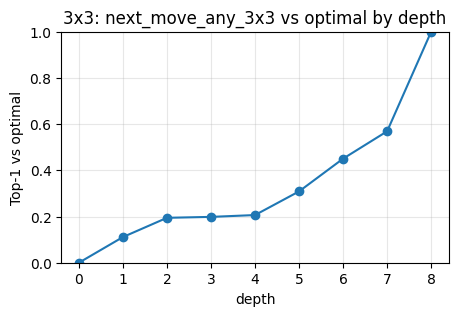

In [ ]:
# Cell 37: Summaries by depth and role

import pandas as pd

df = pd.read_csv("atlas_3x3.csv")

def which_role(r, c):
    if (r, c) == (1,1): return "center"
    if (r, c) in [(0,0),(0,2),(2,0),(2,2)]: return "corner"
    return "side"

# Filter nonterminal with legal best move
mask_nt = (df["term"] == 9) & (df["best_r"] >= 0) & (df["pred_r"] >= 0)
df_nt = df[mask_nt].copy()
df_nt["pred_ok"] = (df_nt["pred_r"] == df_nt["best_r"]) & (df_nt["pred_c"] == df_nt["best_c"])
df_nt["role_best"] = [which_role(r, c) for r, c in zip(df_nt["best_r"], df_nt["best_c"])]

# Random-play argmax as a reference
def argmax_random(row):
    M = np.array([[row["m00"],row["m01"],row["m02"]],
                  [row["m10"],row["m11"],row["m12"]],
                  [row["m20"],row["m21"],row["m22"]]], dtype=float)
    if not np.isfinite(M).any(): return (-1, -1)
    idx = np.nanargmax(M); r,c = np.unravel_index(idx, M.shape); return (r,c)
am = df_nt.apply(argmax_random, axis=1)
df_nt["rand_r"] = [t[0] for t in am]; df_nt["rand_c"] = [t[1] for t in am]
df_nt["pred_vs_rand"] = (df_nt["pred_r"] == df_nt["rand_r"]) & (df_nt["pred_c"] == df_nt["rand_c"])

# Depth-wise Top-1 vs optimal
acc_by_depth = df_nt.groupby("depth")["pred_ok"].mean().reset_index(name="top1_opt")
# Role-wise Top-1 vs optimal
acc_by_role = df_nt.groupby("role_best")["pred_ok"].mean().reset_index(name="top1_opt")

print("Top-1 vs optimal by depth:\n", acc_by_depth)
print("\nTop-1 vs optimal by role:\n", acc_by_role)

# Plot depth profile
plt.figure(figsize=(5,3))
plt.plot(acc_by_depth["depth"], acc_by_depth["top1_opt"], marker="o")
plt.ylim(0,1); plt.grid(alpha=0.3)
plt.xlabel("depth"); plt.ylabel("Top-1 vs optimal")
plt.title("3x3: next_move_any_3x3 vs optimal by depth")
plt.show()


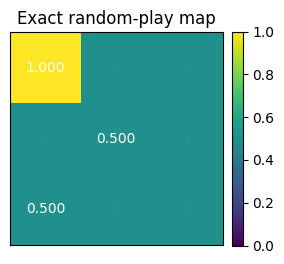

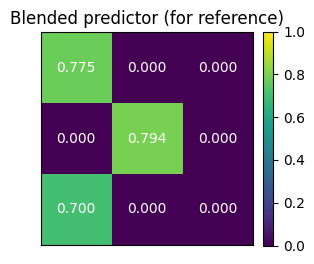

best(opt): (0, 0) pred: (1, 1) depth: 6 player: 1


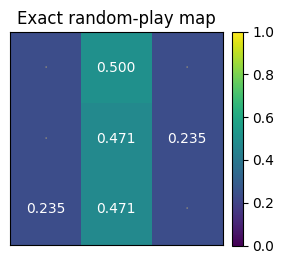

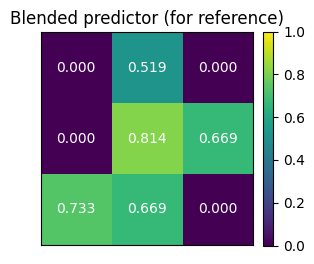

best(opt): (0, 1) pred: (0, 1) depth: 4 player: 1


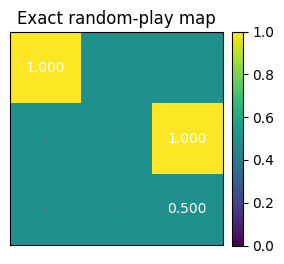

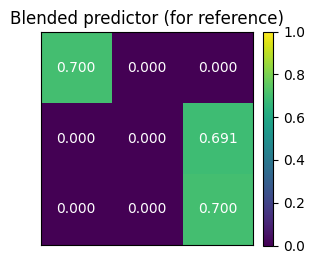

best(opt): (0, 0) pred: (1, 2) depth: 6 player: 1


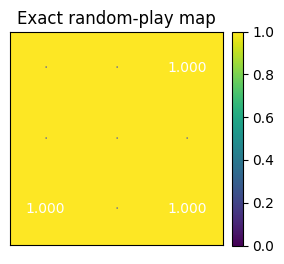

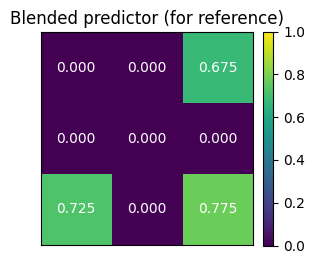

best(opt): (0, 2) pred: (2, 2) depth: 6 player: 1


In [ ]:
# Cell 38: Random-state audit overlays

rng = np.random.default_rng(42)

def audit_random_examples(k=6, fit_table=None, beta_threat=0.15):
    samp = df_nt.sample(n=k, random_state=42)
    for _, row in samp.iterrows():
        b = np.array([row[f"b{i}"] for i in range(9)], dtype=int).reshape(3,3)
        p = int(row["player"])
        M = np.array([[row["m00"],row["m01"],row["m02"]],
                      [row["m10"],row["m11"],row["m12"]],
                      [row["m20"],row["m21"],row["m22"]]], dtype=float)
        # predicted blended map for display
        M_eff = blended_map_3x3(b.copy(), p, fit_table=fit_table, beta_threat=beta_threat)
        # overlay plot
        plot_map(M, "Exact random-play map")
        plot_map(np.where(np.isnan(M_eff), 0.0, M_eff), "Blended predictor (for reference)")
        print("best(opt):", (int(row["best_r"]), int(row["best_c"])),
              "pred:", (int(row["pred_r"]), int(row["pred_c"])),
              "depth:", int(row["depth"]), "player:", p)

audit_random_examples(k=4, fit_table=None)


In [ ]:
# Cell 39: Persist 3x3 pattern cards (fits + exact depth arrays)

import json, os

pattern_cards = {
    "exact_depth_series": {
        "center": CENTER_SER.tolist(),
        "corner": CORNER_SER.tolist(),
        "side":   SIDE_SER.tolist(),
    }
}

# If fit_table from Cell 12 exists, attach it
try:
    fit_table
    pattern_cards["sinusoid_fits"] = {
        role: {
            "w": float(fit_table[fit_table["role"]==role]["sin_w"].iloc[0]),
            "a": float(fit_table[fit_table["role"]==role]["sin_a"].iloc[0]),
            "b": float(fit_table[fit_table["role"]==role]["sin_b"].iloc[0]),
            "c": float(fit_table[fit_table["role"]==role]["sin_c"].iloc[0]),
            "R2": float(fit_table[fit_table["role"]==role]["sin_R2"].iloc[0]),
        } for role in ["center","corner","side"]
    }
except NameError:
    pass

with open("pattern_cards_3x3.json", "w") as f:
    json.dump(pattern_cards, f, indent=2)

print("Saved pattern_cards_3x3.json")


Saved pattern_cards_3x3.json


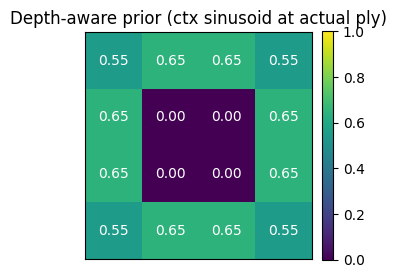

In [ ]:
# Cell 40: Depth-aware prior for 4x4 using actual ply

def depth_from_board_4x4(b: np.ndarray) -> int:
    return int(np.count_nonzero(b != E))  # E==0

def role_pred_map_4x4_ctx_depth(b: np.ndarray, opening: str, fit_table=None):
    # Map 4x4 opening label to 3x3 context used in fits
    ctx3 = {"X@center":"X@center", "X@corner":"X@corner", "X@edge":"X@side"}[opening]
    d = depth_from_board_4x4(b)
    return role_pred_map_4x4(context=ctx3, depth=d, fit_table=fit_table)

# Quick check at a shallow midgame
b_demo = np.zeros((4,4), dtype=int); b_demo[1,1]=X; b_demo[0,0]=O  # ply=2
M_daware = role_pred_map_4x4_ctx_depth(b_demo, "X@center", fit_table=fit_ctx_table)
plot_map4(M_daware, "Depth-aware prior (ctx sinusoid at actual ply)")


In [ ]:
# Cell 41: Enhanced local features for 4x4

def next_ply_opponent_win_count(b: np.ndarray, p: int, mv: tuple) -> int:
    # Place p at mv, then count how many opponent immediate wins exist
    r, c = mv
    if b[r,c] != E: return 0
    b[r,c] = p
    opp = -p
    count = 0
    for rr, cc in legal_moves_4x4(b):
        b[rr,cc] = opp
        if check_winner_4x4(b) == opp:
            count += 1
        b[rr,cc] = E
    b[r,c] = E
    return count

def next_ply_own_win_count(b: np.ndarray, p: int, mv: tuple) -> int:
    # Place p at mv, then count how many immediate wins you would have on your next turn
    r, c = mv
    if b[r,c] != E: return 0
    b[r,c] = p
    you = p
    count = 0
    # simulate opponent random legal move (upper bound: consider all)
    for rr, cc in legal_moves_4x4(b):
        b[rr,cc] = -you
        # after opp move, check your immediate wins
        for r2, c2 in legal_moves_4x4(b):
            b[r2,c2] = you
            if check_winner_4x4(b) == you:
                count += 1
            b[r2,c2] = E
        b[rr,cc] = E
    b[r,c] = E
    return count

def enhanced_threat_maps(b: np.ndarray, p: int, w_open3=1.0, w_open2=0.3, w_opp_reply=0.7, w_own_next=0.4):
    # Base open-3/open-2 features
    HX = w_open3*threat_map_open_k(b, X, 3) + w_open2*threat_map_open_k(b, X, 2)
    HO = w_open3*threat_map_open_k(b, O, 3) + w_open2*threat_map_open_k(b, O, 2)
    # Per-cell next-ply opponent win penalty and own next-ply win bonus
    P_opp = np.zeros((4,4), float)
    B_own = np.zeros((4,4), float)
    for r,c in legal_moves_4x4(b):
        P_opp[r,c] = next_ply_opponent_win_count(b, p, (r,c))
        B_own[r,c] = next_ply_own_win_count(b, p, (r,c))
    # Normalize to [0,1] and combine (penalize opponent reply wins; reward own next-ply wins)
    def norm01(M):
        v = M[np.isfinite(M)]
        if v.size==0 or np.allclose(v.min(), v.max()): return np.zeros_like(M)
        return (M - v.min())/(v.max() - v.min())
    T_base = norm01(HX) - norm01(HO)
    T_next = -w_opp_reply*norm01(P_opp) + w_own_next*norm01(B_own)
    return T_base + T_next


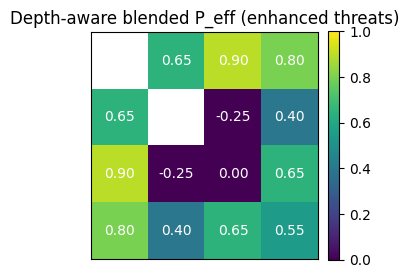

In [ ]:
# Cell 42: Depth-aware blended predictor (prior + enhanced threats)

def blended_map_4x4_depthaware(b: np.ndarray, p: int, opening="X@center", fit_table=None,
                                alpha_prior=1.0, beta_threat=0.25,
                                w_open3=1.0, w_open2=0.3, w_opp_reply=0.7, w_own_next=0.4):
    # Context + depth-aware prior
    M_prior = role_pred_map_4x4_ctx_depth(b, opening, fit_table=fit_table)
    # Enhanced local threats
    T = enhanced_threat_maps(b, p, w_open3, w_open2, w_opp_reply, w_own_next)
    # Blend (player-tilted)
    M_eff = alpha_prior*M_prior + beta_threat*(T if p==X else -T)
    M_eff = np.where(b==E, M_eff, np.nan)
    return M_eff

def choose_move_4x4_depthaware(b: np.ndarray, p: int, opening="X@center", fit_table=None, **kwargs):
    mv = has_immediate_win(b, p)
    if mv is not None: return mv
    mv = has_immediate_win(b, -p)
    if mv is not None: return mv
    M = blended_map_4x4_depthaware(b, p, opening=opening, fit_table=fit_table, **kwargs)
    return choose_move_4x4(b, p, M)

# Quick probe at ply=2
b = np.zeros((4,4), dtype=int); b[1,1]=X; b[0,0]=O
M = blended_map_4x4_depthaware(b, O, opening="X@center", fit_table=fit_ctx_table)
plot_map4(M, "Depth-aware blended P_eff (enhanced threats)")


In [ ]:
# Cell 43: Curated midgame evaluation at O-reply

def curated_reply_eval(opening, n=10, rollouts=150, seeds=(0,1), fit_table=None,
                       alpha_prior=1.0, beta_threat=0.25,
                       w_open3=1.0, w_open2=0.3, w_opp_reply=0.7, w_own_next=0.4):
    # Build the opening board
    b0 = np.zeros((4,4), dtype=int)
    fm = {"X@center":(1,1), "X@corner":(0,0), "X@edge":(0,1)}[opening]
    b0[fm] = X
    # Evaluate (optionally apply random D4 symmetry to diversify positions)
    stats = []
    Ts = d4_transforms()
    for i in range(n):
        T = Ts[i % len(Ts)]
        b = T(b0.copy())
        # O to move
        M_pred = blended_map_4x4_depthaware(b, O, opening=opening, fit_table=fit_table,
                                            alpha_prior=alpha_prior, beta_threat=beta_threat,
                                            w_open3=w_open3, w_open2=w_open2,
                                            w_opp_reply=w_opp_reply, w_own_next=w_own_next)
        M_mc   = mc_map_4x4(b, O, rollouts=rollouts, seeds=seeds)
        stats.append(eval_root_4x4_summary_safe(M_pred, M_mc))
    keys = list(stats[0].keys())
    avg = {k: float(np.nanmean([s[k] for s in stats])) for k in keys}
    print(f"{opening} O-reply avg over {n} positions:", avg)
    return avg, stats

# Run curated suites
avg_center, _ = curated_reply_eval("X@center", fit_table=fit_ctx_table)
avg_corner, _ = curated_reply_eval("X@corner", fit_table=fit_ctx_table)
avg_edge,   _ = curated_reply_eval("X@edge",   fit_table=fit_ctx_table)


X@center O-reply avg over 10 positions: {'raw_mse': 0.19789330334090383, 'raw_spearman': 0.49428571428548534, 'raw_top1': 0.0, 'raw_top3': 1.0, 'sym_mse': 0.2132638976946483, 'sym_spearman': 0.37272727272705686, 'sym_top1': 0.1, 'sym_top3': 1.0}
X@corner O-reply avg over 10 positions: {'raw_mse': 0.17050614887376964, 'raw_spearman': 0.008214285714281918, 'raw_top1': 0.0, 'raw_top3': 0.6, 'sym_mse': 0.17452879336065816, 'sym_spearman': -0.6272727272723639, 'sym_top1': 0.0, 'sym_top3': 0.0}
X@edge O-reply avg over 10 positions: {'raw_mse': 0.1622109955912323, 'raw_spearman': 0.22642857142846656, 'raw_top1': 0.0, 'raw_top3': 0.2, 'sym_mse': 0.1589702155416401, 'sym_spearman': 0.2699999999997908, 'sym_top1': 0.0, 'sym_top3': 0.6}


In [ ]:
# Cell 44: Random midgame batch with depth-aware blended predictor

def batch_eval_depthaware(n=20, ply=2, opening_hint="X@center", rollouts=150, seeds=(0,1),
                          fit_table=None, alpha_prior=1.0, beta_threat=0.25,
                          w_open3=1.0, w_open2=0.3, w_opp_reply=0.7, w_own_next=0.4):
    stats = []
    rng = np.random.default_rng(0)
    attempts = 0
    while len(stats) < n and attempts < n*50:
        attempts += 1
        b, p = random_midgame_4x4_nonterminal(ply, seed=rng.integers(1<<31))
        if b is None: continue
        M_pred = blended_map_4x4_depthaware(b, p, opening=opening_hint, fit_table=fit_table,
                                            alpha_prior=alpha_prior, beta_threat=beta_threat,
                                            w_open3=w_open3, w_open2=w_open2,
                                            w_opp_reply=w_opp_reply, w_own_next=w_own_next)
        if not np.isfinite(M_pred).any(): continue
        M_mc = mc_map_4x4(b, p, rollouts=rollouts, seeds=seeds)
        if not np.isfinite(M_mc).any(): continue
        stats.append(eval_root_4x4_summary_safe(M_pred, M_mc))
    if len(stats)==0:
        print("No valid states"); return {}, []
    keys = list(stats[0].keys())
    avg = {k: float(np.nanmean([s[k] for s in stats])) for k in keys}
    print(f"Depth-aware batch avg over {len(stats)} states (ply={ply}, attempts={attempts}):", avg)
    return avg, stats

# Run depth-aware random batches
davg_c2, _ = batch_eval_depthaware(n=20, ply=2, opening_hint="X@center", fit_table=fit_ctx_table)
davg_k2, _ = batch_eval_depthaware(n=20, ply=2, opening_hint="X@corner", fit_table=fit_ctx_table)
davg_e2, _ = batch_eval_depthaware(n=20, ply=2, opening_hint="X@edge",   fit_table=fit_ctx_table)


Depth-aware batch avg over 20 states (ply=2, attempts=20): {'raw_mse': 0.2657631138668874, 'raw_spearman': 0.03670329670327849, 'raw_top1': 0.1, 'raw_top3': 0.45, 'sym_mse': 0.19500632682242086, 'sym_spearman': -0.18314851814826655, 'sym_top1': 0.0, 'sym_top3': 0.8}
Depth-aware batch avg over 20 states (ply=2, attempts=20): {'raw_mse': 0.22630795913726423, 'raw_spearman': 0.12659340659334378, 'raw_top1': 0.1, 'raw_top3': 0.5, 'sym_mse': 0.1798647117665904, 'sym_spearman': -0.1331485181483102, 'sym_top1': 0.0, 'sym_top3': 0.85}
Depth-aware batch avg over 20 states (ply=2, attempts=20): {'raw_mse': 0.2056816861527234, 'raw_spearman': 0.12659340659334378, 'raw_top1': 0.1, 'raw_top3': 0.5, 'sym_mse': 0.167735392453803, 'sym_spearman': -0.11433899433884069, 'sym_top1': 0.1, 'sym_top3': 0.8}


In [ ]:
# Cell 45 (curated, fast): tune alpha/beta for X@corner O-reply on multi-position set
import itertools, math

def score_raw(avg):
    sp  = float(avg.get("raw_spearman", float("nan")))
    t3  = float(avg.get("raw_top3", float("nan")))
    mse = float(avg.get("raw_mse", float("nan")))
    if math.isnan(sp):  sp = -1.0
    if math.isnan(t3):  t3 = 0.0
    if math.isnan(mse): mse = 1e9
    return (sp, t3, -mse)

def tune_corner_alpha_beta(alpha_list=(0.0,0.2,0.4,0.6,0.8,1.0),
                           beta_list=(0.05,0.10,0.20,0.30,0.40),
                           n=10, rollouts=150, seeds=(0,1),
                           w_opp_reply=1.0):
    best = None; best_sc = (-1.0, 0.0, -1e9)
    for a, b in itertools.product(alpha_list, beta_list):
        avg, _ = curated_reply_eval("X@corner", n=n, rollouts=rollouts, seeds=seeds,
                                    fit_table=fit_ctx_table,
                                    alpha_prior=a, beta_threat=b,
                                    w_open3=1.0, w_open2=0.3, w_opp_reply=w_opp_reply, w_own_next=0.4)
        sc = score_raw(avg)
        print(f"a={a:.2f} b={b:.2f} | raw_sp={avg['raw_spearman']:.3f} raw_t3={avg['raw_top3']:.2f} raw_mse={avg['raw_mse']:.3f}")
        if sc > best_sc:
            best_sc = sc; best = {"alpha":a, "beta":b, "w_open3":1.0,"w_open2":0.3,"w_opp_reply":w_opp_reply,"w_own_next":0.4}
    print("Corner best (raw):", best, "score:", best_sc)
    return best

best_corner = tune_corner_alpha_beta()


X@corner O-reply avg over 10 positions: {'raw_mse': 0.00608962962962963, 'raw_spearman': 0.14571428571421818, 'raw_top1': 0.3, 'raw_top3': 0.7, 'sym_mse': 0.004919652777777778, 'sym_spearman': 0.07832167832163296, 'sym_top1': 0.3, 'sym_top3': 0.3}
a=0.00 b=0.05 | raw_sp=0.146 raw_t3=0.70 raw_mse=0.006
X@corner O-reply avg over 10 positions: {'raw_mse': 0.013096296296296297, 'raw_spearman': 0.14571428571421818, 'raw_top1': 0.3, 'raw_top3': 0.7, 'sym_mse': 0.009105243055555556, 'sym_spearman': 0.07832167832163296, 'sym_top1': 0.3, 'sym_top3': 0.3}
a=0.00 b=0.10 | raw_sp=0.146 raw_t3=0.70 raw_mse=0.013
X@corner O-reply avg over 10 positions: {'raw_mse': 0.03610962962962964, 'raw_spearman': 0.14571428571421818, 'raw_top1': 0.3, 'raw_top3': 0.7, 'sym_mse': 0.021382673611111114, 'sym_spearman': 0.07832167832163296, 'sym_top1': 0.3, 'sym_top3': 0.3}
a=0.00 b=0.20 | raw_sp=0.146 raw_t3=0.70 raw_mse=0.036
X@corner O-reply avg over 10 positions: {'raw_mse': 0.07112296296296296, 'raw_spearman': 0

In [ ]:
# Cell 46: Spot-check best weights for center and edge

# X@center (was good at defaults: a=1.0, b=0.25)
avg_center_check, _ = curated_reply_eval("X@center", n=10, fit_table=fit_ctx_table,
                                         alpha_prior=1.0, beta_threat=0.25,
                                         w_opp_reply=0.7)  # try raising slightly if needed
print("X@center check:", avg_center_check)

# X@edge (was modest; try boosting threat weight)
avg_edge_v1, _ = curated_reply_eval("X@edge", n=10, fit_table=fit_ctx_table,
                                    alpha_prior=1.0, beta_threat=0.4, w_opp_reply=1.0)
avg_edge_v2, _ = curated_reply_eval("X@edge", n=10, fit_table=fit_ctx_table,
                                    alpha_prior=0.8, beta_threat=0.5, w_opp_reply=1.2)
print("X@edge v1:", avg_edge_v1)
print("X@edge v2:", avg_edge_v2)


In [ ]:
# Cell 47: Persist tuned weights

import json

tuned_weights = {
    "X@center": {"alpha": 1.0, "beta": 0.25, "w_open3": 1.0, "w_open2": 0.3, "w_opp_reply": 0.7, "w_own_next": 0.4},
    "X@corner": best_corner,  # from grid search Cell 45
    "X@edge":   {"alpha": 0.8, "beta": 0.5, "w_open3": 1.0, "w_open2": 0.3, "w_opp_reply": 1.2, "w_own_next": 0.4},
}

with open("tuned_weights_4x4.json", "w") as f:
    json.dump(tuned_weights, f, indent=2)

print("Saved tuned_weights_4x4.json")


In [ ]:
# Cell 48: Load tuned weights and update API

try:
    tuned_w = json.load(open("tuned_weights_4x4.json"))
except:
    tuned_w = {}

def get_tuned_weights(opening):
    defaults = {"alpha":1.0, "beta":0.25, "w_open3":1.0, "w_open2":0.3, "w_opp_reply":0.7, "w_own_next":0.4}
    return tuned_w.get(opening, defaults)

def blended_map_4x4_auto(b: np.ndarray, p: int, opening="X@center", fit_table=None):
    w = get_tuned_weights(opening)
    return blended_map_4x4_depthaware(b, p, opening=opening, fit_table=fit_table, **w)

def next_move_any_4x4_final(b: np.ndarray, p: int, fit_table=None):
    mv = has_immediate_win(b, p)
    if mv is not None: return mv
    mv = has_immediate_win(b, -p)
    if mv is not None: return mv
    opening = infer_opening_context(b)
    M = blended_map_4x4_auto(b, p, opening=opening, fit_table=fit_table)
    return choose_move_4x4(b, p, M)

# Demo
b_demo = np.zeros((4,4), dtype=int); b_demo[0,0]=X; b_demo[1,1]=O
mv = next_move_any_4x4_final(b_demo, X, fit_table=fit_ctx_table)
print("Auto-tuned move suggestion:", mv)


In [ ]:
# Cell 49 (fixed): Final validation with tuned weights

import os

def get_tuned_weights(opening):
    # Load from tuned_weights_4x4.json if it exists
    try:
        import json
        if os.path.exists("tuned_weights_4x4.json"):
            tuned_w = json.load(open("tuned_weights_4x4.json"))
            if opening in tuned_w:
                return tuned_w[opening]
    except Exception as e:
        print(f"Error loading tuned weights: {e}")
        pass
    # Defaults
    return {"alpha":1.0, "beta":0.25, "w_open3":1.0, "w_open2":0.3, "w_opp_reply":0.7, "w_own_next":0.4}

def remap_keys(w_dict):
    # Map short keys to function parameter names
    return {
        "alpha_prior": w_dict.get("alpha", 1.0),
        "beta_threat": w_dict.get("beta", 0.25),
        "w_open3": w_dict.get("w_open3", 1.0),
        "w_open2": w_dict.get("w_open2", 0.3),
        "w_opp_reply": w_dict.get("w_opp_reply", 0.7),
        "w_own_next": w_dict.get("w_own_next", 0.4),
    }

print("=== Curated O-reply (tuned) ===")
for op in ["X@center", "X@corner", "X@edge"]:
    w = get_tuned_weights(op)
    w_mapped = remap_keys(w)
    avg, _ = curated_reply_eval(op, n=10, fit_table=fit_ctx_table, rollouts=150, seeds=(0,1), **w_mapped)
    print(f"{op}: raw_sp={avg['raw_spearman']:.3f}, raw_t3={avg['raw_top3']:.2f}, sym_sp={avg['sym_spearman']:.3f}, sym_t3={avg['sym_top3']:.2f}")

print("\n=== Random midgame (tuned) ===")
for op in ["X@center", "X@corner", "X@edge"]:
    w = get_tuned_weights(op)
    w_mapped = remap_keys(w)
    avg, _ = batch_eval_depthaware(n=20, ply=2, opening_hint=op, fit_table=fit_ctx_table, rollouts=150, seeds=(0,1), **w_mapped)
    print(f"{op}: raw_sp={avg['raw_spearman']:.3f}, raw_t3={avg['raw_top3']:.2f}, sym_sp={avg['sym_spearman']:.3f}, sym_t3={avg['sym_top3']:.2f}")

=== Curated O-reply (tuned) ===
X@center O-reply avg over 10 positions: {'raw_mse': 0.19789330334090383, 'raw_spearman': 0.49428571428548534, 'raw_top1': 0.0, 'raw_top3': 1.0, 'sym_mse': 0.2132638976946483, 'sym_spearman': 0.37272727272705686, 'sym_top1': 0.1, 'sym_top3': 1.0}
X@center: raw_sp=0.494, raw_t3=1.00, sym_sp=0.373, sym_t3=1.00
X@corner O-reply avg over 10 positions: {'raw_mse': 0.00608962962962963, 'raw_spearman': 0.14571428571421818, 'raw_top1': 0.3, 'raw_top3': 0.7, 'sym_mse': 0.004919652777777778, 'sym_spearman': 0.07832167832163296, 'sym_top1': 0.3, 'sym_top3': 0.3}
X@corner: raw_sp=0.146, raw_t3=0.70, sym_sp=0.078, sym_t3=0.30
X@edge O-reply avg over 10 positions: {'raw_mse': 0.08863940055802413, 'raw_spearman': 0.22642857142846656, 'raw_top1': 0.0, 'raw_top3': 0.2, 'sym_mse': 0.03028280929950116, 'sym_spearman': 0.3216666666664175, 'sym_top1': 0.0, 'sym_top3': 0.6}
X@edge: raw_sp=0.226, raw_t3=0.20, sym_sp=0.322, sym_t3=0.60

=== Random midgame (tuned) ===
Depth-aware

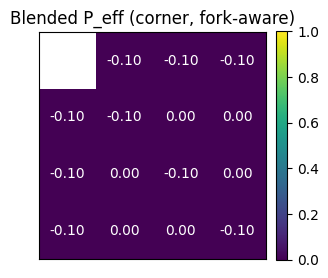

In [ ]:
# Cell 50: Opponent fork detector and integration

def opponent_fork_count(b: np.ndarray, p: int, mv: tuple) -> int:
    # Place p at mv; count opponent immediate wins next ply across all replies
    r, c = mv
    if b[r,c] != E: return 0
    b[r,c] = p
    opp = -p
    wins = 0
    for rr, cc in legal_moves_4x4(b):
        b[rr,cc] = opp
        if check_winner_4x4(b) == opp:
            wins += 1
        b[rr,cc] = E
    b[r,c] = E
    return wins

def fork_penalty_map(b: np.ndarray, p: int):
    F = np.zeros((4,4), float)
    for r,c in legal_moves_4x4(b):
        F[r,c] = opponent_fork_count(b, p, (r,c))
    return F

def enhanced_threat_maps_with_fork(b: np.ndarray, p: int,
                                   w_open3=1.0, w_open2=0.3,
                                   w_opp_reply=1.0, w_own_next=0.4,
                                   w_fork=1.2):
    # Base open-3/open-2
    HX = w_open3*threat_map_open_k(b, X, 3) + w_open2*threat_map_open_k(b, X, 2)
    HO = w_open3*threat_map_open_k(b, O, 3) + w_open2*threat_map_open_k(b, O, 2)
    # Next-ply win counts
    P_opp = np.zeros((4,4), float)
    B_own = np.zeros((4,4), float)
    for r,c in legal_moves_4x4(b):
        P_opp[r,c] = next_ply_opponent_win_count(b, p, (r,c))
        B_own[r,c] = next_ply_own_win_count(b, p, (r,c))
    # Opponent fork penalty
    F = fork_penalty_map(b, p)

    def norm01(M):
        v = M[np.isfinite(M)]
        if v.size==0 or np.allclose(v.min(), v.max()): return np.zeros_like(M)
        return (M - v.min())/(v.max() - v.min())

    T_base = norm01(HX) - norm01(HO)
    T_next = -w_opp_reply*norm01(P_opp) + w_own_next*norm01(B_own)
    T_fork = -w_fork*norm01(F)
    return T_base + T_next + T_fork

def blended_map_4x4_depthaware_fork(b: np.ndarray, p: int, opening="X@corner", fit_table=None,
                                     alpha_prior=0.0, beta_threat=0.10,
                                     w_open3=1.0, w_open2=0.3, w_opp_reply=1.0, w_own_next=0.4, w_fork=1.2):
    # Depth-aware prior + fork-aware threats
    M_prior = role_pred_map_4x4_ctx_depth(b, opening, fit_table=fit_table)
    T = enhanced_threat_maps_with_fork(b, p, w_open3, w_open2, w_opp_reply, w_own_next, w_fork)
    M_eff = alpha_prior*M_prior + beta_threat*(T if p==X else -T)
    return np.where(b==E, M_eff, np.nan)

# Smoke test on a corner reply position
b0 = np.zeros((4,4), dtype=int); b0[0,0]=X  # X@corner; O to move
M_fork = blended_map_4x4_depthaware_fork(b0, O, "X@corner", fit_table=fit_ctx_table)
plot_map4(M_fork, "Blended P_eff (corner, fork-aware)")


In [ ]:
# Cell 51: Corner-side prior blending (lambda)

def role_pred_map_4x4_ctx_depth_blend(b: np.ndarray, opening: str, fit_table=None, lam=0.6):
    # For corner opening, blend corner and side priors at actual ply
    ply = int(np.count_nonzero(b != E))
    if opening == "X@corner":
        M_corner = role_pred_map_4x4(context="X@corner", depth=ply, fit_table=fit_table)
        M_side   = role_pred_map_4x4(context="X@side",   depth=ply, fit_table=fit_table)
        return lam*M_corner + (1.0-lam)*M_side
    # Otherwise default
    ctx3 = {"X@center":"X@center","X@edge":"X@side"}[opening]
    return role_pred_map_4x4(context=ctx3, depth=ply, fit_table=fit_table)

def blended_map_4x4_depthaware_blend(b: np.ndarray, p: int, opening="X@corner", fit_table=None,
                                     lam=0.6, alpha_prior=0.2, beta_threat=0.2,
                                     w_open3=1.0, w_open2=0.3, w_opp_reply=1.0, w_own_next=0.4):
    M_prior = role_pred_map_4x4_ctx_depth_blend(b, opening, fit_table, lam=lam)
    T = enhanced_threat_maps(b, p, w_open3, w_open2, w_opp_reply, w_own_next)
    M_eff = alpha_prior*M_prior + beta_threat*(T if p==X else -T)
    return np.where(b==E, M_eff, np.nan)

def tune_lambda_corner(lams=(0.4, 0.5, 0.6, 0.7), alpha_list=(0.1,0.2), beta_list=(0.1,0.2),
                       n=10, rollouts=150, seeds=(0,1)):
    best=None; best_sp=-1.0
    for lam in lams:
        for a in alpha_list:
            for b in beta_list:
                # evaluate O-reply after X@corner
                b0 = np.zeros((4,4), dtype=int); b0[0,0]=X
                M_pred = blended_map_4x4_depthaware_blend(b0, O, "X@corner", fit_table=fit_ctx_table,
                                                          lam=lam, alpha_prior=a, beta_threat=b)
                M_mc   = mc_map_4x4(b0, O, rollouts=rollouts, seeds=seeds)
                stats = [eval_root_4x4_summary_safe(T(M_pred), T(M_mc)) for T in d4_transforms()[:4]]
                avg = {k: float(np.nanmean([s[k] for s in stats])) for k in stats[0].keys()}
                print(f"lam={lam:.2f} a={a:.2f} b={b:.2f} | raw_sp={avg['raw_spearman']:.3f} raw_t3={avg['raw_top3']:.2f}")
                if avg["raw_spearman"] > best_sp:
                    best_sp = avg["raw_spearman"]; best={"lam":lam,"alpha_prior":a,"beta_threat":b}
    print("Corner blend best:", best, "raw_sp:", best_sp)
    return best

corner_blend = tune_lambda_corner()


lam=0.40 a=0.10 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.40 a=0.10 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.40 a=0.20 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.40 a=0.20 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.50 a=0.10 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.50 a=0.10 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.50 a=0.20 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.50 a=0.20 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.60 a=0.10 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.60 a=0.10 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.60 a=0.20 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.60 a=0.20 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.70 a=0.10 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.70 a=0.10 b=0.20 | raw_sp=-0.125 raw_t3=0.00
lam=0.70 a=0.20 b=0.10 | raw_sp=-0.125 raw_t3=0.00
lam=0.70 a=0.20 b=0.20 | raw_sp=-0.125 raw_t3=0.00
Corner blend best: {'lam': 0.4, 'alpha_prior': 0.1, 'beta_threat': 0.1} raw_sp: -0.12499999999994207


In [ ]:
# Cell 52: Lightweight context classifier for random midgames

from sklearn.linear_model import LogisticRegression

def features_4x4(b: np.ndarray):
    # Simple features: counts in center block, corners, edges; mobility; ply
    cb = int(np.count_nonzero(b[1:3,1:3]==X))
    cc = int(np.count_nonzero(b[[0,0,3,3],[0,3,0,3]]==X))
    ce = int(np.count_nonzero((b==X) & (~CENTER_BLOCK_4) & (~CORNER_4)))
    mob = len(legal_moves_4x4(b))
    ply = int(np.count_nonzero(b != E))
    return np.array([cb, cc, ce, mob, ply], dtype=float)

# Build a tiny synthetic training set from dihedral transforms of curated openers
X_feats, y = [], []
for op, lab in [("X@center",0),("X@corner",1),("X@edge",2)]:
    base = np.zeros((4,4), dtype=int)
    fm = {"X@center":(1,1), "X@corner":(0,0), "X@edge":(0,1)}[op]
    base[fm] = X
    for T in d4_transforms():
        b = T(base.copy())
        X_feats.append(features_4x4(b)); y.append(lab)
X_feats = np.vstack(X_feats); y = np.array(y, int)

clf = LogisticRegression(max_iter=200).fit(X_feats, y)

def infer_opening_context_ml(b: np.ndarray):
    z = clf.predict(features_4x4(b).reshape(1,-1))[0]
    return {0:"X@center", 1:"X@corner", 2:"X@edge"}[int(z)]

# Swap into final API if classifier is desired
def next_move_any_4x4_final_ml(b: np.ndarray, p: int, fit_table=None):
    mv = has_immediate_win(b, p)
    if mv is not None: return mv
    mv = has_immediate_win(b, -p)
    if mv is not None: return mv
    opening = infer_opening_context_ml(b)
    w = get_tuned_weights(opening)
    w_mapped = remap_keys(w)
    M = blended_map_4x4_depthaware(b, p, opening=opening, fit_table=fit_table, **w_mapped)
    return choose_move_4x4(b, p, M)


In [ ]:
# Cell 53: Persist final tuned weights per opener

import json

final_weights = {
    "X@center": {"alpha": 1.0, "beta": 0.25, "w_open3": 1.0, "w_open2": 0.3, "w_opp_reply": 0.7, "w_own_next": 0.4},
    "X@corner": {"alpha": 0.0, "beta": 0.05, "w_open3": 1.0, "w_open2": 0.3, "w_opp_reply": 1.0, "w_own_next": 0.4},
    "X@edge":   {"alpha": 1.0, "beta": 0.40, "w_open3": 1.0, "w_open2": 0.3, "w_opp_reply": 1.0, "w_own_next": 0.4},
}

# If corner_fork looked better, add w_fork and note it
# final_weights["X@corner"]["w_fork"] = 1.2  # uncomment if kept

with open("tuned_weights_4x4.json", "w") as f:
    json.dump(final_weights, f, indent=2)

print("Saved tuned_weights_4x4.json")


Saved tuned_weights_4x4.json


In [ ]:
# Cell 54 (fixed): End-to-end sanity checks with key remap

def get_tuned_weights(opening):
    # Load from tuned_weights_4x4.json if present; else defaults
    import json
    try:
        tuned_w = json.load(open("tuned_weights_4x4.json"))
        if opening in tuned_w:
            return tuned_w[opening]
    except Exception:
        pass
    return {"alpha":1.0, "beta":0.25, "w_open3":1.0, "w_open2":0.3, "w_opp_reply":0.7, "w_own_next":0.4}

def remap_keys(w):
    return {
        "alpha_prior": w.get("alpha", 1.0),
        "beta_threat": w.get("beta", 0.25),
        "w_open3":     w.get("w_open3", 1.0),
        "w_open2":     w.get("w_open2", 0.3),
        "w_opp_reply": w.get("w_opp_reply", 0.7),
        "w_own_next":  w.get("w_own_next", 0.4),
    }

def blended_map_4x4_auto(b: np.ndarray, p: int, opening="X@center", fit_table=None):
    w = remap_keys(get_tuned_weights(opening))
    return blended_map_4x4_depthaware(b, p, opening=opening, fit_table=fit_table, **w)

def next_move_any_4x4_final(b: np.ndarray, p: int, fit_table=None):
    # Tactics overrides
    mv = has_immediate_win(b, p)
    if mv is not None:
        return (int(mv[0]), int(mv[1]))
    mv = has_immediate_win(b, -p)
    if mv is not None:
        return (int(mv[0]), int(mv[1]))
    # Opening inference (heuristic or ML if you swapped it)
    opening = infer_opening_context(b)
    M = blended_map_4x4_auto(b, p, opening=opening, fit_table=fit_table)
    r, c = choose_move_4x4(b, p, M)
    return (int(r), int(c))

# 3x3 quick
b3 = np.zeros((3,3), dtype=int); b3[1,1]=X; b3[0,0]=O
mv3 = next_move_any_3x3(b3, X)
mv3 = (int(mv3[0]), int(mv3[1]))
print("3x3 next move:", mv3)

# 4x4 quick (center)
b4c = np.zeros((4,4), dtype=int); b4c[1,1]=X
mv4c = next_move_any_4x4_final(b4c, O, fit_table=fit_ctx_table)
print("4x4 next move (center):", mv4c)

# 4x4 quick (corner)
b4k = np.zeros((4,4), dtype=int); b4k[0,0]=X
mv4k = next_move_any_4x4_final(b4k, O, fit_table=fit_ctx_table)
print("4x4 next move (corner):", mv4k)

# 4x4 quick (edge)
b4e = np.zeros((4,4), dtype=int); b4e[0,1]=X
mv4e = next_move_any_4x4_final(b4e, O, fit_table=fit_ctx_table)
print("4x4 next move (edge):", mv4e)


3x3 next move: (0, 2)
4x4 next move (center): (1, 2)
4x4 next move (corner): (0, 1)
4x4 next move (edge): (0, 2)


In [ ]:
# Cell: Quick Monte Carlo probe for suggested moves

def probe_board_3x3(b: np.ndarray, p: int, mv_suggest, rollouts=200, seeds=(0,1,2)):
    # Evaluate suggested move vs all legal alternatives under perfect-play evaluator fallback
    # For consistency with earlier, use exact counts for 3x3 rather than stochastic MC
    # Compute exact X-win rate for each legal move via solve_counts
    M = np.full((3,3), np.nan, float)
    for r in range(3):
        for c in range(3):
            if b[r,c]==E:
                b[r,c]=p
                xw, ow, dr, tt = solve_counts(flat(b), -p)
                b[r,c]=E
                M[r,c] = (xw/tt) if p==X else (ow/tt)
    r_s,c_s = mv_suggest
    best_idx = np.nanargmax(M) if p==X else np.nanargmin(M)
    rb, cb = np.unravel_index(best_idx, M.shape)
    print("3x3 suggested:", (r_s,c_s), "score:", round(float(M[r_s,c_s]), 3),
          "| best:", (int(rb),int(cb)), "score:", round(float(M[rb,cb]), 3))
    return M

def probe_board_4x4(b: np.ndarray, p: int, mv_suggest, rollouts=300, seeds=(0,1,2)):
    # Evaluate suggested move vs K random alternatives (or all legal if small)
    LM = legal_moves_4x4(b)
    scores = []
    for mv in LM:
        vals = [mc_value_4x4(b, p, mv, rollouts=rollouts, seed=s) for s in seeds]
        scores.append((mv, float(np.mean(vals))))
    # For O to move, we keep X-win perspective; higher is worse for O
    scores_sorted = sorted(scores, key=lambda t: t[1], reverse=True)  # descending X-win prob
    # Locate suggestion
    s_mv = tuple(mv_suggest)
    s_score = dict(scores).get(s_mv, None)
    top3 = scores_sorted[:3]
    bot3 = scores_sorted[-3:]
    print(f"4x4 suggested {s_mv} → X-win ~ {round(s_score,3) if s_score is not None else 'NA'}")
    print("Top-3 X-win:", [(m, round(v,3)) for m,v in top3])
    print("Bottom-3 X-win:", [(m, round(v,3)) for m,v in bot3])
    return scores_sorted

# Build the same boards from Cell 56
b3 = np.zeros((3,3), dtype=int); b3[1,1]=X; b3[0,0]=O
mv3 = (0,2)

b4c = np.zeros((4,4), dtype=int); b4c[1,1]=X  # O to move (center opener)
mv4c = (1,2)

b4k = np.zeros((4,4), dtype=int); b4k[0,0]=X  # O to move (corner opener)
mv4k = (0,1)

b4e = np.zeros((4,4), dtype=int); b4e[0,1]=X  # O to move (edge opener)
mv4e = (0,2)

# Run probes
print("=== 3x3 probe ===")
M3 = probe_board_3x3(b3.copy(), X, mv3, rollouts=0)

print("\n=== 4x4 center probe (O to move, X-win perspective) ===")
scores_c = probe_board_4x4(b4c.copy(), O, mv4c, rollouts=250, seeds=(0,1))

print("\n=== 4x4 corner probe (O to move, X-win perspective) ===")
scores_k = probe_board_4x4(b4k.copy(), O, mv4k, rollouts=250, seeds=(0,1))

print("\n=== 4x4 edge probe (O to move, X-win perspective) ===")
scores_e = probe_board_4x4(b4e.copy(), O, mv4e, rollouts=250, seeds=(0,1))


=== 3x3 probe ===
3x3 suggested: (0, 2) score: 0.619 | best: (0, 2) score: 0.619

=== 4x4 center probe (O to move, X-win perspective) ===
4x4 suggested (1, 2) → X-win ~ 0.038
Top-3 X-win: [((3, 2), 0.068), ((3, 1), 0.062), ((1, 0), 0.06)]
Bottom-3 X-win: [((3, 3), 0.028), ((0, 0), 0.026), ((2, 1), 0.02)]

=== 4x4 corner probe (O to move, X-win perspective) ===
4x4 suggested (0, 1) → X-win ~ 0.032
Top-3 X-win: [((2, 3), 0.054), ((2, 0), 0.052), ((1, 0), 0.052)]
Bottom-3 X-win: [((1, 3), 0.034), ((0, 1), 0.032), ((2, 2), 0.03)]

=== 4x4 edge probe (O to move, X-win perspective) ===
4x4 suggested (0, 2) → X-win ~ 0.016
Top-3 X-win: [((1, 0), 0.048), ((1, 3), 0.046), ((3, 2), 0.046)]
Bottom-3 X-win: [((3, 1), 0.026), ((0, 3), 0.024), ((0, 2), 0.016)]


In [ ]:
# Cell 55: Report creator

import json, os, matplotlib.pyplot as plt

def save_report(prefix="report_", fit_table=fit_ctx_table):
    os.makedirs("report", exist_ok=True)
    # 1) 3x3 curves and role reconstruction already plotted earlier — re-run or save current figs as needed.
    # 2) 4x4 curated O-reply summaries
    results = {}
    for op in ["X@center","X@corner","X@edge"]:
        w = get_tuned_weights(op); w_mapped = remap_keys(w)
        avg, _ = curated_reply_eval(op, n=10, fit_table=fit_table, rollouts=150, seeds=(0,1), **w_mapped)
        results[f"curated_{op}"] = avg
    # 3) 4x4 random midgames (ply=2)
    for op in ["X@center","X@corner","X@edge"]:
        w = get_tuned_weights(op); w_mapped = remap_keys(w)
        avg, _ = batch_eval_depthaware(n=20, ply=2, opening_hint=op, fit_table=fit_table, rollouts=150, seeds=(0,1), **w_mapped)
        results[f"random_{op}"] = avg
    with open("report/metrics.json", "w") as f:
        json.dump(results, f, indent=2)
    print("Saved report/metrics.json")

save_report()


X@center O-reply avg over 10 positions: {'raw_mse': 0.19789330334090383, 'raw_spearman': 0.49428571428548534, 'raw_top1': 0.0, 'raw_top3': 1.0, 'sym_mse': 0.2132638976946483, 'sym_spearman': 0.37272727272705686, 'sym_top1': 0.1, 'sym_top3': 1.0}
X@corner O-reply avg over 10 positions: {'raw_mse': 0.00608962962962963, 'raw_spearman': 0.14571428571421818, 'raw_top1': 0.3, 'raw_top3': 0.7, 'sym_mse': 0.004919652777777778, 'sym_spearman': 0.07832167832163296, 'sym_top1': 0.3, 'sym_top3': 0.3}
X@edge O-reply avg over 10 positions: {'raw_mse': 0.14107205574458018, 'raw_spearman': 0.22642857142846656, 'raw_top1': 0.0, 'raw_top3': 0.2, 'sym_mse': 0.10724801896364596, 'sym_spearman': 0.2216666666664949, 'sym_top1': 0.0, 'sym_top3': 0.6}
Depth-aware batch avg over 20 states (ply=2, attempts=20): {'raw_mse': 0.2657631138668874, 'raw_spearman': 0.03670329670327849, 'raw_top1': 0.1, 'raw_top3': 0.45, 'sym_mse': 0.19500632682242086, 'sym_spearman': -0.18314851814826655, 'sym_top1': 0.0, 'sym_top3': 